# Data Science Capstone Project

# Starbucks Project

## Project Overview

The Starbucks project attempts to capture the perception of the customers towards promotional offers. This project tires to explore the purchasing behavior of the customers when presented with promotional offers. The main goal of this project is to identify the group of customers, who respond positively to the promotional offers and the group of customers who does not respond to promotional offers. 

## Problem Statement

The problem statement is the to examine the effects of  promotional offers on the consumer purcahsing behavior pattern and in which manner should the offers be presented, so that the positive effect of the promotional offers would be maximized. 

## Metrics to Evaluate the Model's Performance

Three metrics are used to evaluate the performance of the model viz. 'precision', 'recall', and 'f1 score'.


- F1 score: The f1 score is used to compare the performances of the different classifiers and to choose best classifier among other classifiers. The F1 score is the best metric to evaluate a model's performance when the data is imbalanced. When the data has imbalanced target classes, only relying on precision and recall is not the best way to analyse the model. As the F1 score is the harmonic mean of both precision and recall, it gives more weight to low values and classifier will get a high F1 value when scores of both precision and recall are reasonably high.


- Precision: Precision is used to kee check on false positives as it is not desirable to have too many customers, who are negative towards promotional offers, get classified as positive customers. 


- Recall: Recall score is very important to this project as we don't want to loose potential customers. If the recall score is low, then there will be plenty of false negatives (positive customers classified as negative one) and this is not good for business. The main goal here is to have high recall score with reasonable precision score like recall score of 0.95 and precision score of 0.75.  

## Importing libraries

In [425]:
# Import necessary libraries
import pandas as pd
import numpy as np
import math
import json
import time
import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier



%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### Portfolio.json

In [426]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [427]:
portfolio.shape

(10, 6)

In [428]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [429]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [430]:
# Portfolio

# Sort 'portfolio' by 'offer_type' column to facilitate the encoding
portfolio = portfolio.sort_values(by='offer_type')
portfolio

portfolio.shape

# Encoding the offer ids
n = 1
for idx, i in portfolio.id.items():
    portfolio.loc[idx, 'enc_offer_ids'] = n
    n += 1

portfolio

,reward,channels,difficulty,duration,offer_type,id,enc_offer_ids
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2.0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3.0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,4.0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6.0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,7.0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,8.0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,9.0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,10.0


Portfolio.json: This dataset contains mainly the details of the promotional offers offered to the customers. The details covered in this dataset are


- Reward (int) – The reward amount given to the customer upon completion of the offer.
- Channels (list of strings) – These are the ways/channels through which the promotional offers were sent to the customers.
- Difficulty (int) – This column contains the minimum amount which must be spent to complete an offer.
- Duration (int) – This column contains the time frame in which offer is valid/open to the customers.
- Offer type (string) – This column contains three different categories of the offer types viz. ‘BOGO,’ ‘discount,’ and ‘informational.’
- Id (string) – These are different ids given to each offer (offer ids).
- enc_offer_ids (int) - This new column contains encoded values for different offers. 

### Profile.json

In [431]:
# Profile

profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [432]:
profile.shape

(17000, 5)

In [433]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [434]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


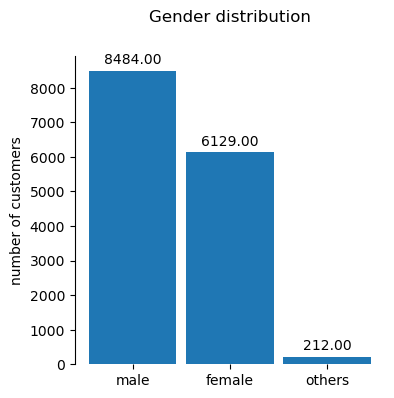

In [435]:
labels = ['male', 'female', 'others']
vals = list(profile.gender.value_counts().values)

fig, ax = plt.subplots(figsize=(4,4))
bar_container = ax.bar(labels, vals, width=0.9)
ax.set(ylabel='number of customers')
ax.set_title('Gender distribution', pad=25)
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(True)
ax.bar_label(bar_container, padding=3, fmt='%.2f');

In [436]:
# Encoding the persons
n = 1
for idx, i in profile.id.items():
    profile.loc[idx, 'person_id'] = n
    n += 1
    
profile

,gender,age,id,became_member_on,income,person_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,5.0
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,16996.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,16997.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,16998.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,16999.0


Profile.json: This dataset contains the demographic details of the users/customers. The details covered in the dataset are


- Age (int) – The age of the customer. This column contains the null value which are represented by the number 118.
- Became_member_on (int) – This column contains the date when the customer created the account with Starbucks.
- Gender (string) – This is the gender of the customer viz. M (male), F (female) and O (others).
- Id (string) – Different ids given to customers (customer ids).
- Income (float) – Customer’s income.
- Person_id - This new column contains the encoded values for different customers.

### Transcript.json

In [437]:
# Transcript

transcript.head()

# Replace the time when it is '0' with '0.01' so that when we do the data cleaning
# later, we can be able to replace nan values with '0'
transcript.loc[transcript.time == 0, 'time'] = 0.01
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.01
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.01
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.01
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0.01
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.01


In [438]:
transcript.shape

(306534, 4)

In [439]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   person  306534 non-null  object 
 1   event   306534 non-null  object 
 2   value   306534 non-null  object 
 3   time    306534 non-null  float64
dtypes: float64(1), object(3)
memory usage: 9.4+ MB


In [440]:
transcript.describe()

,time
count,306534.000000
mean,366.383447
std,200.325385
min,0.010000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


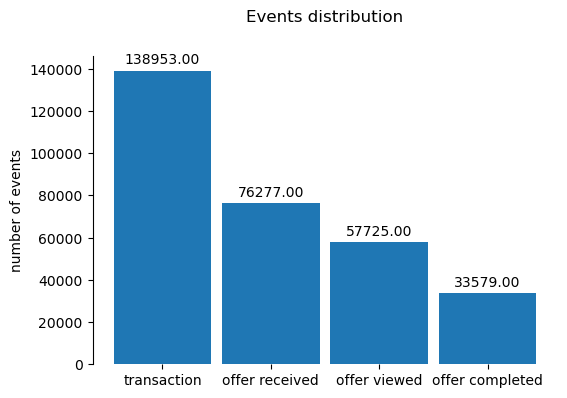

In [441]:
labels = list(transcript.event.value_counts().index)
vals = list(transcript.event.value_counts().values)

fig, ax = plt.subplots(figsize=(6,4))
bar_container = ax.bar(labels, vals, width=0.9)
ax.set(ylabel='number of events')
ax.set_title('Events distribution', pad=25)
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(True)
ax.bar_label(bar_container, padding=3, fmt='%.2f');

Transcript.json: This dataset contains the details of transactions and events performed by the customer after receiving an offer. The details covered in this dataset are


- Event (string) – This column contains the description of every action of every customer towards the offers viz. ‘offer received,’ ‘offer viewed,’ ‘offer completed,’ and ‘transaction.’
- Person (string) – Customer ID.
- Time (int) – This column records time of each event performed by the customers. 
- Value (dictionary of strings) – This column contains a dictionary for each row with values like offer id or transaction amount or both depending upon the event. 

## Data Pre-processing

### Merge 'profile' and 'transcript' datasets

In [442]:
# Merge Profile and Transcript dataframes

# Rename the 'id' column in profile to facilitate merge
profile.rename(columns={'id':'person'}, inplace=True)
df_merge = pd.merge(profile, transcript, on="person")

In [443]:
df_merge.head()

,gender,age,person,became_member_on,income,person_id,event,value,time
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168.0
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216.0
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336.0
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348.0
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,transaction,{'amount': 0.35000000000000003},360.0


In [444]:
# Create 'offer_id', 'amount', and 'reward' columns

def offer_amt_rew(df):
    '''
    Details: Create new 3 columns viz. 'offer_id', 'amt', and 'reward'
             from 'value' column
             
    Input: 
    df - Dataframe obtained after combining 'profile' and 'transcript' 
         datasets
    
    Output:
    df - Dataframe with 3 new columns viz. 'offer_id', 'amt', and 'reward'
    
    '''
    
    # Create 3 empty lists to append values from 'value' column
    offer_id = []
    amt = []
    reward = []
    
    # Iterate 'event' column to capture 'offer id' from 'value' column
    # and append offer ids in 'offer_id' list
    for i in df.value:
        if list(i.keys()) == ['offer id']:
            offer_id.append(pd.Series(i.values())[0])
        elif list(i.keys()) == ['amount']:
            offer_id.append(np.int64(0))
        else:
            offer_id.append(pd.Series(i.values())[0])
            
    
    # Convert 'offer_id' list to dataframe to facilitate merging
    offer_id = pd.DataFrame(offer_id, columns=['offer_id'])
    
    # Iterate 'event' column to capture 'amount' from 'value' column
    # and append offer ids in 'amt' list
    for i in df.value:
        if list(i.keys()) == ['amount']:
            amt.append(pd.Series(i.values())[0])
        else:
            amt.append(np.int64(0))
    
    # Convert 'amt' list to dataframe to facilitate merging
    amt = pd.DataFrame(amt, columns=['amt'])
    
    # Iterate 'event' column to capture 'reward' from 'value' column
    # and append offer ids in 'reward' list
    for i in df.value:
        if list(i.keys()) == ['offer_id', 'reward']:
            reward.append(pd.Series(i.values())[1])
        else:
            reward.append(np.int64(0))
    
    # Convert 'reward' list to dataframe to facilitate merging
    reward = pd.DataFrame(reward, columns=['reward'])
    
    
    # Finally merge all three columns with the 'df' dataset
    df = pd.concat([df, offer_id, amt, reward], axis=1)
    
    return df

In [445]:
# Create the 'offer_id', 'amt' and 'reward' columns
df_merge = offer_amt_rew(df_merge)

In [447]:
df_merge.head()

,gender,age,person,became_member_on,income,person_id,event,value,time,offer_id,amt,reward
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168.0,2906b810c7d4411798c6938adc9daaa5,0.00,0
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216.0,2906b810c7d4411798c6938adc9daaa5,0.00,0
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,0
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,transaction,{'amount': 0.35000000000000003},360.0,0,0.35,0


### Merge all three datasets

In [448]:
# Merge 'df_merge' and 'portfolio' dataframes

# Merge 'df_merge' and 'portfolio'
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
df_merge = pd.merge(df_merge, portfolio, on="offer_id", how='outer')


In [449]:
df_merge.head()

,gender,age,person,became_member_on,income,person_id,event,value,time,offer_id,amt,reward_x,reward_y,channels,difficulty,duration,offer_type,enc_offer_ids
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168.00,2906b810c7d4411798c6938adc9daaa5,0.0,0,2.0,"[web, email, mobile]",10.0,7.0,discount,8.0
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1.0,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216.00,2906b810c7d4411798c6938adc9daaa5,0.0,0,2.0,"[web, email, mobile]",10.0,7.0,discount,8.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,6.0,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.01,2906b810c7d4411798c6938adc9daaa5,0.0,0,2.0,"[web, email, mobile]",10.0,7.0,discount,8.0
3,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,6.0,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},18.00,2906b810c7d4411798c6938adc9daaa5,0.0,0,2.0,"[web, email, mobile]",10.0,7.0,discount,8.0
4,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,7.0,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408.00,2906b810c7d4411798c6938adc9daaa5,0.0,0,2.0,"[web, email, mobile]",10.0,7.0,discount,8.0


## Data Cleaning

### Handling Categorical Variables

In [450]:
# The 'age' column has null values which is '118'. Replace the value 
# 118 with null value
df_merge.loc[(df_merge.age == 118), 'age'] = np.nan

# Creating dummy variables from the column 'offer_types'
df_merge = pd.get_dummies(df_merge, columns=['offer_type', 'event'])
df_merge.rename(columns={'offer_type_bogo':'bogo',
                         'offer_type_discount':'discount',
                         'offer_type_informational':'inform',
                         'event_offer completed':'completed',
                         'event_offer received':'received',
                         'event_offer viewed':'viewed',
                         'event_transaction':'transaction'}, 
                inplace=True)

# Drop 'reward_y' column and rename 'reward_x' column into 'reward'
# and 'enc_offer_id' column into 'offer_ids'
df_merge.drop('reward_y', axis=1, inplace=True)
df_merge.rename(columns={'reward_x':'reward',
                        'enc_offer_ids':'offer_ids'}, inplace=True)

# Sort the values according to 'person' and 'time' and reset the index
df_merge.sort_values(by=['person', 'time'], inplace=True)
df_merge.reset_index(inplace=True)
df_merge.drop('index', axis=1, inplace=True)

# Split the 'channels' column into three columns
start = time.time()
for idx, i in df_merge.channels.items():
    if type(i) == list:
        for j in i:
            if j == 'email':
                df_merge.loc[idx, 'email'] = 1
            elif j == 'mobile':
                df_merge.loc[idx, 'mobile'] = 1
            elif j == 'social':
                df_merge.loc[idx, 'social'] = 1
            elif j == 'web':
                df_merge.loc[idx, 'web'] = 1
            else:
                pass
print(time.time() - start)

# Encode each gender type with different numbers in a new column 
# 'gender_id'
df_merge.loc[(df_merge.gender == 'M'), 'gender_id'] = 1
df_merge.loc[(df_merge.gender == 'F'), 'gender_id'] = 2
df_merge.loc[(df_merge.gender == 'O'), 'gender_id'] = 3

# Create a new column 'dur_hours', which shows time in hours, 
# from 'duration' column 
df_merge['dur_hours'] = df_merge.duration.apply(lambda x: x*24)

# Create another column 'expr' (short for expiry) which shows 
# expiration of an informational offer in real time

temp_df = df_merge[df_merge.received == 1]
df_merge['expr'] = df_merge.loc[temp_df.index, ].dur_hours + df_merge.loc[temp_df.index, ].time

# Convert became_member_on columns into datetime format and 
# create a new column 'memb_days' which depicts the number of days 
# a person has been a member
df_merge['member_date'] = pd.to_datetime(df_merge.became_member_on, 
                                         format='%Y%m%d')
df_merge['memb_yrs'] = df_merge.member_date.apply(lambda x: 
                                                  ((date.today() - x.date()).days) / 365)
df_merge.drop('member_date', axis=1, inplace=True)

# Replace null values with 0 from the columns that contain null values,
# except for the columns 'gender' and 'income' as they contain null values
# which are present from the beginning and are not caused by the merge.
# Null values from all the other columns are created because of the merge like
# 'duration', 'difficulty', which are not present for independent transaction rows

impute_cols = ['channels', 'difficulty', 'duration', 'offer_ids',
              'email', 'mobile', 'social', 'web', 'dur_hours', 'expr']
for col in impute_cols:
    df_merge.loc[(df_merge[col].isnull()), col] = 0

# df_merge

83.18145799636841


In [17]:
df_merge.head()

,gender,age,person,became_member_on,income,person_id,value,time,offer_id,amt,...,viewed,transaction,email,mobile,social,web,gender_id,dur_hours,expr,memb_yrs
0,M,33.0,0009655768c64bdeb2e877511632db8f,20170421,72000.0,3794.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168.0,5a8bc65990b245e5a138643cd4eb9837,0.00,...,0,0,1.0,1.0,1.0,0.0,1.0,72.0,240.0,6.249315
1,M,33.0,0009655768c64bdeb2e877511632db8f,20170421,72000.0,3794.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192.0,5a8bc65990b245e5a138643cd4eb9837,0.00,...,1,0,1.0,1.0,1.0,0.0,1.0,72.0,0.0,6.249315
2,M,33.0,0009655768c64bdeb2e877511632db8f,20170421,72000.0,3794.0,{'amount': 22.16},228.0,0,22.16,...,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.249315
3,M,33.0,0009655768c64bdeb2e877511632db8f,20170421,72000.0,3794.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336.0,3f207df678b143eea3cee63160fa8bed,0.00,...,0,0,1.0,1.0,0.0,1.0,1.0,96.0,432.0,6.249315
4,M,33.0,0009655768c64bdeb2e877511632db8f,20170421,72000.0,3794.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372.0,3f207df678b143eea3cee63160fa8bed,0.00,...,1,0,1.0,1.0,0.0,1.0,1.0,96.0,0.0,6.249315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,F,45.0,ffff82501cea40309d5fdd7edcca4a07,20161125,62000.0,1887.0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576.0,2906b810c7d4411798c6938adc9daaa5,0.00,...,0,0,1.0,1.0,0.0,1.0,2.0,168.0,0.0,6.652055
306530,F,45.0,ffff82501cea40309d5fdd7edcca4a07,20161125,62000.0,1887.0,{'amount': 14.23},576.0,0,14.23,...,0,1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.652055
306531,F,45.0,ffff82501cea40309d5fdd7edcca4a07,20161125,62000.0,1887.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582.0,2906b810c7d4411798c6938adc9daaa5,0.00,...,1,0,1.0,1.0,0.0,1.0,2.0,168.0,0.0,6.652055
306532,F,45.0,ffff82501cea40309d5fdd7edcca4a07,20161125,62000.0,1887.0,{'amount': 10.12},606.0,0,10.12,...,0,1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.652055


## Transform the Data into Desired Form

### Bogo and Discount Offers

- In this section the aim is to transform the data into such format which can be utilised as input data for ML algorithms.


- When an offer is sent to a user, the details regarding that offer is given in multiple rows (2, 3, or 4 rows). For example, there is a row meant for when offer is received, viewed, completed etc. Hence the aim here is to restructure the data in such a way that all the data regarding a single offer is captured in a single row.


- The thought process here is to loop through each 'user' and within each user, loop through each offer sent to the user and capture the relevant data regarding that offer into one row. The data collected while looping are,
    - person_id
    - offer_id
    - received (1 for yes, 0 for no)
    - time of receipt
    - viewed (1 for yes, 0 for no)
    - time when offer is viewed
    - completed (1 for yes, 0 for no)
    - completion time
    - transaction (1 for yes, 0 for no)
    - time when the transaction is done
    - And other demographic details of the user like 'gender', 'age', 'income', 'became member on' etc.
    - And other details related to the offer like 'channels', 'difficulty', 'duration', 'reward' etc.

    
- The offer completion is quite tricky as there are several instances where one transaction completes multiple offers. Hence a for loop has been written to identify maximum number of offers completed by one transaction. 


- After identifying the maximum number of offers completed by one offer, I have written conditions while looping through users, which cover all the possible cases of offer completions by one transaction. 

In [22]:
# This small for loop shows us maximum number offers are completed in one transaction
m = []
n = []
for i in df_merge.completed:
    if i == 1:
        n.append(1)
        m.append(np.sum(n))
    else:
        n.clear()

max(m)

3

In [23]:
start = time.time()
def clean_ids(df_merge=df_merge):
    '''
    Details: Instead of multiple rows (each for an event like 'received', 'viewed', 
             'completed' etc.), a single line with all the demographic details of people
             along with details regarding
             
             1. Whether the offer is 'receievd' by the user and the 'time of receipt'
             2. Whether the offer is 'viewed' by the user and the 'viewed time'
             3. Whether the offer is 'completed' by the user and the 'time of completion'
             4. And the data regarding 'transaction', 'time of transaction', amount' spent 
                and 'reward' given (only for discount offers)
    
    Input: (Only one default argument)
    df_merge - A dataframe which is obtained from combining all the three datasets
               viz. 'profile', 'portfolio', and 'transcript'
    
    Output:
    df_num - Dataset which contains details of an offer in a single row for each user
    idxs = Indices of transactions which are associated with offer completions and to be 
           excluded from further data trnasformative steps
    '''
    
    # An empty dataframe to which cleaned data is added at the end
    df_num = pd.DataFrame(columns=['person_id', 'offer_id', 'received', 'received_time',
                                   'gender_id', 'age', 'income', 'enc_email',
                                   'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                   'bogo', 'discount', 'inform',
                                   'dur_hours', 'memb_yrs', 'expr'])
    
    # Dataframe which contains data with only 'bogo' and 'discount' offers
    df_merge_1 = df_merge[df_merge.offer_ids.isin([1,2,3,4,5,6,7,8])]
    
    # An empty list which is used to hold indices of 'transactions' which are asoociated
    # with offer completions. This will help in processing 'independent transactions' and 
    # 'informational offers'
    idxs = []
    
    # Group the data with 'person_id' and 'offer_ids'
    df_gb = df_merge_1.groupby(['person_id', 'offer_ids'])
    
    # Iterate through 'df_gb'. One offer, one person at a time
    for i, j in df_gb:
            
        # Temporary dataframe to hold the captured data
        # Here the length of the dataframe is set to number of offers received because 
        # it is logically not possible to have extra rows other than offers which are received
        # by the user. Whether the offer is completed or not, we have to capture every details
        # of each offer which is received by the user
        df1 = pd.DataFrame(columns=['person_id', 'offer_id', 'received', 'received_time',
                                    'gender_id', 'age', 'income', 'enc_email',
                                    'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                    'bogo', 'discount', 'inform',
                                    'dur_hours', 'memb_yrs', 'expr'],
                           index = [i for i in range(len(j[j.received == 1]))])

        # Iterate through 'received' column of a single offer. Number of 'received' is the 
        # number of rows. Then insert the 'received' data into 'df1'
        for idx, i in zip(j[j.received == 1].received.index, range(len(df1))):
            lst = (df_merge.person_id.iloc[idx], df_merge.offer_ids.iloc[idx], df_merge.received.iloc[idx],
                   df_merge.time.iloc[idx], df_merge.gender_id.iloc[idx], df_merge.age.iloc[idx],
                   df_merge.income.iloc[idx], df_merge.email.iloc[idx], df_merge.mobile.iloc[idx],
                   df_merge.social.iloc[idx], df_merge.web.iloc[idx], df_merge.difficulty.iloc[idx],
                   df_merge.duration.iloc[idx], df_merge.bogo.iloc[idx], df_merge.discount.iloc[idx],
                   df_merge.inform.iloc[idx], df_merge.dur_hours.iloc[idx],
                   df_merge.memb_yrs.iloc[idx], df_merge.expr.iloc[idx])

            df1.loc[i, ['person_id', 'offer_id', 'received', 'received_time', 'gender_id', 'age',
                        'income', 'enc_email', 'enc_mobile', 'enc_social', 'enc_web', 
                        'difficulty', 'duration', 'bogo', 'discount', 'inform',
                        'dur_hours', 'memb_yrs', 'expr']] = lst

        # Iterate through 'viewed' column of a single offer and insert the data into
        # 'df1' dataframe
        for idx, i in zip(j[j.viewed == 1].viewed.index, range(len(df1))):
            lst1 = (df_merge.viewed.iloc[idx], df_merge.time.iloc[idx])
            df1.loc[i, ['viewed', 'viewed_time']] = lst1

            
        # Now iterate through 'completed' column and insert the data into 'df1'
        # A condition has been written to place the completion time of the offer infront of
        # relevant offer. This is because a person may have received two offers but he ignored 
        # first one and completed the second one. Hence the completion time should be infront
        # of second offer. This if-else situation arises when an offer is received multiple times
        # and completed only once or less than number of times offer is received.
        lst2 = np.zeros((1, 2))
        if len(j[j.received == 1].index) > len(j[j.completed == 1].index):

            # When offer completions are less than number of offer receipts
            for idx in (j[j.completed == 1].index):

                for r, hr, i in zip(j[j.received == 1].index, j.dur_hours.index,
                                   range(len(df1))):
                    # Calculate the expiry of the offer
                    expry = df_merge.time.iloc[r] + df_merge.dur_hours.iloc[hr]

                    # If offer completion is greater than expiry then this is not
                    # the offer which has been completed and vice-versa other way around
                    if df_merge.time.iloc[idx] > expry:
                        lst2[0] = (0, 0)
                    elif (df_merge.time.iloc[idx] <= expry):
                        lst2[0] = (df_merge.completed.iloc[idx], df_merge.time.iloc[idx])

                        break

                df1.loc[i, ['completed', 'completed_time']] = lst2[0]

        else:
            
            # When offer receipts are equal to offer completions or there are no offer completions
            # then we don't have to worry much and place offer completion time in ascending order
            # infront of each offer.
            for idx, r, hr, i in zip(j[j.completed == 1].index,
                                     j[j.received == 1].index, j.dur_hours.index,
                                     range(len(df1))):
                expry = df_merge.time.iloc[r] + df_merge.dur_hours.iloc[hr]

                if (df_merge.time.iloc[idx] <= expry):
                    lst2[0] = (df_merge.completed.iloc[idx], df_merge.time.iloc[idx])

                df1.loc[i, ['completed', 'completed_time']] = lst2[0]

        
        ## Now to capture transaction data, we will iterate through 'completed'
        # column of the offer id, then check for different conditions where 
        # an offer can be completed. For example two offers can be completed
        # with only one transactions or three offers can be completed with one
        # transaction. Hence multiple conditions are written to check
        # whether an offer is completed through any of the conditions mentioned
        # below
        ## The same rule above in offer completion time applies here as well. Here also
        # we write if-else condition when number of completions are less than number
        # of offer receipts and number of offer completions are zero or equal to 
        # number of offer receipts.
        
        lst3 = np.zeros((1, 4))
    
        if len(j[j.received == 1].index) > len(j[j.completed == 1].index): 
            for idx in (j[j.completed == 1].index):

                for r, hr, i in zip(j[j.received == 1].index, j.dur_hours.index,
                                   range(len(df1))):

                    expry = df_merge.time.iloc[r] + df_merge.dur_hours.iloc[hr]

                    # When one offer is completed with one transaction, and either transaction
                    # comes first or an offer completion comes first

                    if (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-1]) and \
                    (df_merge.amt.iloc[idx-1] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx-1)
                        lst3[0] = (df_merge.transaction.iloc[idx-1], 
                                   df_merge.time.iloc[idx], 
                                   df_merge.amt.iloc[idx-1], 
                                   df_merge.reward.iloc[idx])
                        break

                    elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+1]) and \
                    (df_merge.amt.iloc[idx+1] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx+1)
                        lst3[0] = (df_merge.transaction.iloc[idx+1],
                                   df_merge.time.iloc[idx],
                                   df_merge.amt.iloc[idx+1],
                                   df_merge.reward.iloc[idx])
                        break


                    # When two offers are completed with one transaction, and either transaction
                    # comes first or offer completions come first

                    elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-2]) and \
                    (df_merge.amt.iloc[idx-2] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx-2)
                        lst3[0] = (df_merge.transaction.iloc[idx-2], 
                                   df_merge.time.iloc[idx], 
                                   df_merge.amt.iloc[idx-2], 
                                   df_merge.reward.iloc[idx])
                        break

                    elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+2]) and \
                    (df_merge.amt.iloc[idx+2] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx+2)
                        lst3[0] = (df_merge.transaction.iloc[idx+2], 
                                   df_merge.time.iloc[idx], 
                                   df_merge.amt.iloc[idx+2], 
                                   df_merge.reward.iloc[idx])
                        break

                    # When three offers are completed with one transaction, and either transaction
                    # comes first or offer completions come first

                    elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-3]) and \
                    (df_merge.amt.iloc[idx-3] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx-3)
                        lst3[0] = (df_merge.transaction.iloc[idx-3], 
                                   df_merge.time.iloc[idx], 
                                   df_merge.amt.iloc[idx-3], 
                                   df_merge.reward.iloc[idx])
                        break

                    elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+3]) and \
                    (df_merge.amt.iloc[idx+3] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx+3)
                        lst3[0] = (df_merge.transaction.iloc[idx+3], 
                                   df_merge.time.iloc[idx], 
                                   df_merge.amt.iloc[idx+3], 
                                   df_merge.reward.iloc[idx])
                        break

                    # When four offers are completed with one transaction, and either transaction
                    # comes first or offer completions come first
                    elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-4]) and \
                    (df_merge.amt.iloc[idx-4] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx-4)
                        lst3[0] = (df_merge.transaction.iloc[idx-4], 
                                   df_merge.time.iloc[idx], 
                                   df_merge.amt.iloc[idx-4], 
                                   df_merge.reward.iloc[idx])
                        break

                    elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+4]) and \
                    (df_merge.amt.iloc[idx+4] != 0) and \
                    (df_merge.time.iloc[idx] <= expry):
                        idxs.append(idx+4)
                        lst3[0] = (df_merge.transaction.iloc[idx+4], 
                                   df_merge.time.iloc[idx], 
                                   df_merge.amt.iloc[idx+4], 
                                   df_merge.reward.iloc[idx])


                        break


                # Add the transaction data into 'df1'
                df1.loc[i, ['transaction', 'transaction_time', 'amount', 'reward']] = lst3[0]

            
        else:
        
            for idx, r, hr, i in zip(j[j.completed == 1].index,
                                     j[j.received == 1].index, j.dur_hours.index,
                                     range(len(df1))):
                expry = df_merge.time.iloc[r] + df_merge.dur_hours.iloc[hr]
            
                # When one offer is completed with one transaction, and either transaction
                # comes first or an offer completion comes first
                if (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-1]) and \
                (df_merge.amt.iloc[idx-1] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx-1)
                    lst3[0] = (df_merge.transaction.iloc[idx-1], 
                               df_merge.time.iloc[idx], 
                               df_merge.amt.iloc[idx-1], 
                               df_merge.reward.iloc[idx])

                elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+1]) and \
                (df_merge.amt.iloc[idx+1] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx+1)
                    lst3[0] = (df_merge.transaction.iloc[idx+1],
                               df_merge.time.iloc[idx],
                               df_merge.amt.iloc[idx+1],
                               df_merge.reward.iloc[idx])

                # When two offers are completed with one transaction, and either transaction
                # comes first or offer completions come first
                elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-2]) and \
                (df_merge.amt.iloc[idx-2] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx-2)
                    lst3[0] = (df_merge.transaction.iloc[idx-2], 
                               df_merge.time.iloc[idx], 
                               df_merge.amt.iloc[idx-2], 
                               df_merge.reward.iloc[idx])

                elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+2]) and \
                (df_merge.amt.iloc[idx+2] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx+2)
                    lst3[0] = (df_merge.transaction.iloc[idx+2], 
                               df_merge.time.iloc[idx], 
                               df_merge.amt.iloc[idx+2], 
                               df_merge.reward.iloc[idx])

                # When three offers are completed with one transaction, and either transaction
                # comes first or offer completions come first
                elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-3]) and \
                (df_merge.amt.iloc[idx-3] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx-3)
                    lst3[0] = (df_merge.transaction.iloc[idx-3], 
                               df_merge.time.iloc[idx], 
                               df_merge.amt.iloc[idx-3], 
                               df_merge.reward.iloc[idx])

                elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+3]) and \
                (df_merge.amt.iloc[idx+3] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx+3)
                    lst3[0] = (df_merge.transaction.iloc[idx+3], 
                               df_merge.time.iloc[idx], 
                               df_merge.amt.iloc[idx+3], 
                               df_merge.reward.iloc[idx])

                # When four offers are completed with one transaction, and either transaction
                # comes first or offer completions come first
                elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx-4]) and \
                (df_merge.amt.iloc[idx-4] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx-4)
                    lst3[0] = (df_merge.transaction.iloc[idx-4], 
                               df_merge.time.iloc[idx], 
                               df_merge.amt.iloc[idx-4], 
                               df_merge.reward.iloc[idx])

                elif (df_merge.time.iloc[idx] == df_merge.time.iloc[idx+4]) and \
                (df_merge.amt.iloc[idx+4] != 0) and \
                (df_merge.time.iloc[idx] <= expry):
                    idxs.append(idx+4)
                    lst3[0] = (df_merge.transaction.iloc[idx+4], 
                               df_merge.time.iloc[idx], 
                               df_merge.amt.iloc[idx+4], 
                               df_merge.reward.iloc[idx])

                    break


                # Add the transaction data into 'df1'
                df1.loc[i, ['transaction', 'transaction_time', 'amount', 'reward']] = lst3[0]

        # Finally add all the 'received', 'viewed', 'completed' and 'transaction' etc data
        # into the main dataframe 'df_num'
        df_num = pd.concat([df_num, df1])
            
    return df_num, idxs
            
time.time() - start

0.0

In [24]:
# Restructuring of 'bogo' and 'discount' offers dataset
start = time.time()
df1, idx = clean_ids()
time.time() - start

2085.0268952846527

In [29]:
# We have missing values in some columns apart from 'gender_id', 'age', and income.
# Hence we will impute them with zero.
# create a list with column names in which we want to replace the null values
impute_cols2 = ['viewed', 'viewed_time', 'completed', 'completed_time', 'transaction',
               'transaction_time', 'amount', 'reward']
for col in impute_cols2:
    df1.loc[(df1[col].isnull()), col] = 0

### Informational Offers

#### Details in case of offer completions

- To map the offer completion for informational offers, the thoght process is the 'calculation of expiration time of the offer from the time it has been viewed by the user upto the offer expiration'. From the moment the offer has been viewed by the user upto its expiration time, if a transaction fall under the time frame of offer view to expiration of the offer, then it is considered as the 'offer completion'. This depicts the thought that the user has made that transaction under the influence of the offer.

- The below function extracts the rows in which offer_ids are 9, 10 or 0. offer_ids '9' and '10' are informational offers and offer_id '0' stands for transactions. From these transactions we have to extract those transactions which come under the expiration time frame of an offer. Hence, the function basically filters out those transactions which are done under the expiration time frames of inforamtional offers. 

In [31]:
def clean_infor1(indices, df_merge=df_merge):
    
    '''
    Details: Extract those transactions which were made under the 
             influence of informational offers
    
    Input:
    indices - Indices of transactions which are associated with offer completions
              of 'bogo' and 'discount' offers
    df_merge (default argument) - A dataframe which is obtained from combining all the three datasets
                                  viz. 'profile', 'portfolio', and 'transcript'
    
    Output:
    df1 - Dataframe which includes all those transactions which fall under the
          time frame between offer view time and expiration time of an informational offer and
          considered as transactions which were made under the influence of an informational offer
    indices - Indices of transactions which fall under the influence of an offer and hence
              to be excluded from independent transactions
    '''
    
    # Create an empty dataframe so that we can add data as we iterate through the targetted dataset
    df_num = pd.DataFrame(columns=['r_index', 'v_index', 't_index',
                                   'person_id', 'offer_id', 'received', 'received_time',
                                   'gender_id', 'age', 'income', 'enc_email',
                                   'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                   'bogo', 'discount', 'inform',
                                   'viewed', 'viewed_time',
                                   'completed', 'completed_time', 'transaction', 'transaction_time',
                                   'amount', 'reward', 'dur_hours', 'expr', 'memb_yrs'])

    
    # Extract the data only with offer ids 0, 9 and 10 and exclude the indices of 
    # transactions associated with offer completions of 'bogo' and 'discount' offers
    df_infor = df_merge.loc[(df_merge.offer_ids.isin([0,9,10])) & ~(df_merge.index.isin(indices))]

    
    # Create an empty list to append indices of offer id 0 (transactions) to filter them out
    # while processing independent transactions
    idxs = []

    # Group the 'df_infor' dataset by 'person_id'
    for i, j in df_infor.groupby('person_id'):
        
        # If the offer is not viewed, then the offer is not considered as completed
        if sum(j.viewed) > 0:
            
            # Iterate through unique offer ids
            for k in j.offer_ids.unique():
                
                # Processing the offer id 9 data
                if k == 9:
                    df = j[j.offer_ids.isin([0,9])]
                    
                    # Create an empty dataframe df1 to capture cleaned data with offer id 9
                    # and set the lenght of the dataframe to the length of number of offer id 9
                    # received (one row for one id)
                    df1 = pd.DataFrame(columns=['r_index', 'v_index', 't_index',
                                                'person_id', 'offer_id', 'received', 'received_time',
                                                'gender_id', 'age','income', 'enc_email',
                                                'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                                'bogo', 'discount', 'inform',
                                                'viewed', 'viewed_time',
                                                'completed', 'completed_time', 'transaction', 'transaction_time',
                                                'amount', 'reward', 'dur_hours', 'expr', 'memb_yrs'],
                                      index = [x for x in range(len(df[df.received == 1].index))])
                    
                    # An empty list to capture the viewed indices so that they do not get repeated
                    v_idxs = []
                    
                    # First loop through 'received' indices
                    # At the end of the loop, the loop is broke in such a way that only one transaction
                    # is considered as offer completion as to maintain protocol of there will be 
                    # only one offer completion for an offer
                    for l in (df[df.received == 1].index):
                        
                        # Record the maximum time limit within which a offer has to be completed
                        tm2 = df_merge.expr.iloc[l]
                        
                        # Loop through 'viewed' indices
                        for m in df[df.viewed == 1].index:
                            
                            # Exclude previously processed 'viewed' indices
                            if (m not in v_idxs):
                                v_idxs.append(m)
                                
                                # Record the starting time of the offer
                                tm1 = df_merge.time.iloc[m]
                                
                                # Now loop through the transactions
                                for t in df[df.transaction == 1].index:
                                    
                                    # Filter out the transactions whose time falls between 'tm1' and 'tm2'
                                    if ((df_merge.time.iloc[t] >= tm1) & (df_merge.time.iloc[t] <=tm2)):
                                        
                                        # Append the transaction index which satisfies the above criteria
                                        idxs.append(t)

                                        # Store all the required values
                                        lst2 = (df_merge[df_merge.index == l].index.values[0],
                                                df_merge[df_merge.index == m].index.values[0],
                                                df_merge[df_merge.index == t].index.values[0],
                                                df_merge.person_id.iloc[l], df_merge.offer_ids.iloc[l], 
                                                df_merge.received.iloc[l], df_merge.time.iloc[l],
                                                df_merge.gender_id.iloc[l], df_merge.age.iloc[l],
                                                df_merge.income.iloc[l],
                                                df_merge.email.iloc[l], df_merge.mobile.iloc[l], 
                                                df_merge.social.iloc[l], df_merge.web.iloc[l],
                                                df_merge.difficulty.iloc[l], df_merge.duration.iloc[l],
                                                df_merge.bogo.iloc[l], df_merge.discount.iloc[l],
                                                df_merge.inform.iloc[l],
                                                df_merge.viewed.iloc[m], df_merge.time.iloc[m], 1, 
                                                df_merge.time.iloc[t], df_merge.transaction.iloc[t], 
                                                df_merge.time.iloc[t], df_merge.amt.iloc[t], 
                                                df_merge.reward.iloc[t], df_merge.dur_hours.iloc[l], 
                                                df_merge.expr.iloc[l], df_merge.memb_yrs.iloc[l])
                                        
                                        # Insert the above data to 'df1'
                                        df1.loc[len(df1.index), ['r_index', 'v_index', 't_index',
                                                                 'person_id', 'offer_id', 'received', 
                                                                 'received_time', 'gender_id', 'age', 
                                                                 'income', 'enc_email',
                                                                 'enc_mobile', 'enc_social', 'enc_web', 
                                                                 'difficulty', 'duration',
                                                                 'bogo', 'discount', 'inform',
                                                                 'viewed', 'viewed_time',
                                                                 'completed', 'completed_time', 
                                                                 'transaction', 'transaction_time',
                                                                 'amount', 'reward', 'dur_hours', 
                                                                 'expr', 'memb_yrs']] = lst2
                                        break
                                        

                                    else:
                                        pass
                                break
                                
                            

                    # Now finally add the offer id 9 data to main dataframe 'df_num'
                    df_num = pd.concat([df_num, df1])

                # Processing the offer id 10 data
                elif k == 10:
                    df = j[j.offer_ids.isin([0,10])]
                    
                    # Create an empty dataframe df1 to capture cleaned data with offer id 10
                    # and set the lenght of the dataframe to the length of number of offer id 10
                    # received (one row for one id)
                    df1 = pd.DataFrame(columns=['r_index', 'v_index', 't_index',
                                                'person_id', 'offer_id', 'received', 'received_time',
                                                'gender_id', 'age', 'income', 'enc_email',
                                                'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                                'bogo', 'discount', 'inform',
                                                'viewed', 'viewed_time',
                                                'completed', 'completed_time', 'transaction', 'transaction_time',
                                                'amount', 'reward', 'dur_hours', 'expr', 'memb_yrs'],
                                      index = [x for x in range(len(df[df.received == 1].index))])
                    
                    # An empty list to capture the viewed indices so that they do not get repeated
                    v_idxs = []
                    
                    # First loop through 'received' indices
                    for l in (df[df.received == 1].index):
                        
                        # Record the maximum time limit within which a offer has to be completed
                        tm2 = df_merge.expr.iloc[l]

                        # Loop through 'viewed' indices
                        for m in df[df.viewed == 1].index:
                            
                            # Exclude previously processed 'viewed' indices
                            if (m not in v_idxs):
                                v_idxs.append(m)
                                
                                # Record the starting time of the offer
                                tm1 = df_merge.time.iloc[m]

                                # Now loop through the transactions
                                for t in df[df.transaction == 1].index:
                                    
                                    # Filter out the transactions whose time falls between 'tm1' and 'tm2'
                                    if ((df_merge.time.iloc[t] >= tm1) & (df_merge.time.iloc[t] <= tm2)):
                                        
                                        # Append the transaction index which satisfies the above criteria
                                        idxs.append(t)

                                        # Store all the required values
                                        lst2 = (df_merge[df_merge.index == l].index.values[0],
                                                df_merge[df_merge.index == m].index.values[0],
                                                df_merge[df_merge.index == t].index.values[0],
                                                df_merge.person_id.iloc[l], df_merge.offer_ids.iloc[l], 
                                                df_merge.received.iloc[l], df_merge.time.iloc[l],
                                                df_merge.gender_id.iloc[l], df_merge.age.iloc[l],
                                                df_merge.income.iloc[l],
                                                df_merge.email.iloc[l], df_merge.mobile.iloc[l], 
                                                df_merge.social.iloc[l], df_merge.web.iloc[l],
                                                df_merge.difficulty.iloc[l], df_merge.duration.iloc[l],
                                                df_merge.bogo.iloc[l], df_merge.discount.iloc[l],
                                                df_merge.inform.iloc[l],
                                                df_merge.viewed.iloc[m], df_merge.time.iloc[m], 1,
                                                df_merge.time.iloc[t],
                                                df_merge.transaction.iloc[t], df_merge.time.iloc[t],
                                                df_merge.amt.iloc[t], df_merge.reward.iloc[t], 
                                                df_merge.dur_hours.iloc[l], df_merge.expr.iloc[l],
                                                df_merge.memb_yrs.iloc[l])
                                        
                                        # Insert the above data to 'df1'
                                        df1.loc[len(df1.index), ['r_index', 'v_index', 't_index',
                                                                 'person_id', 'offer_id', 'received', 
                                                                 'received_time', 'gender_id', 'age', 
                                                                 'income', 'enc_email',
                                                                 'enc_mobile', 'enc_social', 'enc_web', 
                                                                 'difficulty', 'duration',
                                                                 'bogo', 'discount', 'inform',
                                                                 'viewed', 'viewed_time',
                                                                 'completed', 'completed_time', 
                                                                 'transaction', 'transaction_time',
                                                                 'amount', 'reward', 'dur_hours', 
                                                                 'expr', 'memb_yrs']] = lst2
                                        break

                                        
                                    else:
                                        pass
                                break
                                
                            

                    # Now finally add the offer id 10 data to main dataframe 'df_num'
                    df_num = pd.concat([df_num, df1])



        else:
            pass       
            
    return df_num, idxs

In [32]:
# Transactions made under the influence of informational offers
start = time.time()
df2, indices = clean_infor1(idx, df_merge)
time.time() - start

176.79573798179626

In [34]:
# An empty list 'rem_idx' which holds the indices of informational offers which are converted 
# into offer completions
rem_idx = []
for i, j in zip(df2.r_index[df2.r_index.notna()], df2.v_index[df2.v_index.notna()]):
    rem_idx.append(i)
    rem_idx.append(j)
    
# Indices of transactions which are failed to be converted into offer completions
add_idx = list(np.setdiff1d(list(df_merge[df_merge.offer_ids.isin([9,10])].index.values), rem_idx))

#### Details in case of offers which are not completed

Here we capture those informational offers data which were not completed by the user.

Here also we do the same steps as used in 'bogo' and 'discount' section. 

- Extract those informational offers data which are not completed.
- Group the dataset first by 'person_id' and then by 'offer_id'
- Create a temporary data set to hold the captured data (transactional data like 'offer received', 'received time', offer viewed', 'viewed time' etc., demographic data like 'age', 'gender', 'income' etc., and offer details like 'channels used to send offer', 'duration', 'offer type' etc.) of each offer within a user
- Then append data of each user to the main dataframe which holds all the restructured data

In [35]:
def clean_infor2(idx, df_merge=df_merge):
    
    '''
    Details: The functions processes the data with only informational offers which are not
             converted into offer completions
             
    Inputs:
    idx - Informational offer indices which are to be processed
    df_merge (default arguments) - The dataframe obtained from merging 'portfolio', 'profile',
                                   and 'transaction'
                                   
    Output:
    df_num - Dataframe which contains the processed data regarding uncompleted 9 and 10 informational
             offers
    
    '''
    
    # Dataframe with indices of informational offers which are not considered as offer completions
    df = df_merge[df_merge.offer_ids.isin([9,10])].iloc[df_merge[df_merge.offer_ids.isin([9,10])].index.isin(idx), ]
    
    # An empty dataframe to which cleaned data is added at the end
    df_num = pd.DataFrame(columns=['person_id', 'offer_id', 'received', 'received_time',
                                   'gender_id', 'age', 'income', 'enc_email',
                                   'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                   'bogo', 'discount', 'inform',
                                   'viewed', 'viewed_time',
                                   'completed', 'completed_time', 'transaction', 'transaction_time',
                                   'amount', 'reward', 'dur_hours', 'memb_yrs', 'expr'])

    # Group the 'df' dataframe first by 'person_id' and then by 'offer_ids'. Then
    # iterate through dataframe to clean the dataset
    for i, j in df.groupby(['person_id', 'offer_ids']):
        
        # A temporary empty dataframe which is used to hold the cleaned data temporarily
        # Length of the dataframe is set to number of offers received as every deatils 
        # of one offer is covered in one row
        df1 = pd.DataFrame(columns=['person_id', 'offer_id', 'received', 'received_time',
                                    'gender_id', 'age', 'income', 'enc_email',
                                    'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                    'bogo', 'discount', 'inform',
                                    'viewed', 'viewed_time',
                                    'completed', 'completed_time', 'transaction', 'transaction_time',
                                    'amount', 'reward', 'dur_hours', 'memb_yrs', 'expr'],
                           index = [x for x in range(len(j[j.received == 1]))])

        # Iterate through 'received' columns of each person and add the data to the 
        # df1 dataframe
        for idx, k in zip(j[j.received == 1].received.index, range(len(df1))):
            lst = (df_merge.person_id.iloc[idx], df_merge.offer_ids.iloc[idx],df_merge.received.iloc[idx],
                   df_merge.time.iloc[idx], df_merge.gender_id.iloc[idx],df_merge.age.iloc[idx],
                   df_merge.income.iloc[idx], df_merge.difficulty.iloc[idx],
                   df_merge.duration.iloc[idx], df_merge.bogo.iloc[idx], df_merge.discount.iloc[idx],
                   df_merge.inform.iloc[idx], df_merge.email.iloc[idx],df_merge.mobile.iloc[idx],
                   df_merge.social.iloc[idx], df_merge.web.iloc[idx], df_merge.dur_hours.iloc[idx],
                   df_merge.memb_yrs.iloc[idx], df_merge.expr.iloc[idx])

            df1.loc[k, ['person_id', 'offer_id', 'received', 'received_time', 'gender_id', 'age',
                        'income', 'difficulty', 'duration', 'bogo', 'discount', 'inform',
                        'enc_email', 'enc_mobile', 'enc_social', 
                        'enc_web', 'dur_hours', 'memb_yrs', 'expr']] = lst


        # Iterate through 'viewed' column of each person and add the data to the df1 dataframe
        for idx, k in zip(j[j.viewed == 1].viewed.index, range(len(df1))):
            lst1 = (df_merge.viewed.iloc[idx], df_merge.time.iloc[idx])
            df1.loc[k, ['viewed', 'viewed_time']] = lst1

        # Finally add the data from 'df1' dataframe to main dataframe'df_num'
        df_num = pd.concat([df_num, df1])
        
    return df_num

In [36]:
# Data regarding uncompleted informational offers
start = time.time()
df3 = clean_infor2(add_idx)
time.time() - start

# Concat both 'df' and 'df1' dataframes in 'df' dataframe
df4 = pd.concat([df2, df3])

In [40]:
# Reset the index and drop index column
df4.reset_index(inplace=True)
df4.drop('index', axis=1, inplace=True)

# Dropping the null rows
# Here the thought process is that if the user_id is null then all the row is null.
# Based on that, remove the rows by collecting indices of rows where the user_id is null
drp_idxs = []
for i in range(len(df4.index)):
    if type(df4.person_id.iloc[i]) != np.float64:
        drp_idxs.append(i)
    else:
        pass
    
df4.drop(drp_idxs, inplace=True)

# Reset the index after dropping null rows
df4.reset_index(inplace=True)
df4.drop('index', axis=1, inplace=True)

# drop the first three indices columns
df4.drop(['r_index', 'v_index', 't_index'], axis=1, inplace=True)

# Replace null values which are resulted due to restructuring the data with 0
impute_cols3 = ['enc_social', 'enc_web', 'viewed', 'completed', 'transaction',
       'amount', 'reward', 'viewed_time', 'completed_time', 'transaction_time']
for i in impute_cols3:
    df4.loc[(df4[i].isnull()), i] = 0
    
# Join the indices of transactions which are to excluded from independent transactions
index = idx + indices

### Independent Transactions


- After dealing with all the three offer types, we are left with indivisual transactions where people spend their money without any influence of an offer. These transactions are not affected by the offers. Whoever has more independent transactions, we can tell that, we don't have to send promotional offers to make them purchase or to make a transaction and these people are the ones who make regular purchases and are the regular customers.

In [43]:
def clean_ids1(idxs, df_merge=df_merge):
    
    '''
    Details: Extract only indpendent transaction which are not under the influence of any offer
    
    Inputs:
    
    Positional Arguments:
    idxs - Indices of transactions which are associated with offer completions for all 
           three types of offers viz. bogo, discount and informational
           
    Default Arguments:
    df_merge - A dataframe which is obtained from combining all the three datasets
               viz. 'profile', 'portfolio', and 'transcript'
    
    Output:
    df_num - A dataframe containing all the independent transactions
    
    '''
    
    # Dataframe with only independent transactions i.e., offer id 0
    df_merge_0 = df_merge[df_merge.offer_ids == 0].loc[~df_merge[df_merge.offer_ids == 0].index.isin(idxs), ]

    # Main Dataframe which will hold the cleaned data at the end of the function
    df_num = pd.DataFrame(columns=['person_id', 'offer_id', 'received', 'received_time',
                                   'gender_id', 'age', 'income', 'enc_email',
                                   'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                                   'bogo', 'discount', 'inform',
                                   'viewed', 'viewed_time', 'completed', 'completed_time', 
                                   'transaction', 'transaction_time', 'amount', 'reward', 'dur_hours',
                                   'memb_yrs', 'expr'],
                         index = [i for i in range(len(df_merge_0))])

    # Iterate through 'df_merge_0' dataframe and capture the required data and store it
    # in the 'df_num' datagrame
    for i, j in zip(df_merge_0.index, range(len(df_num))) :
        lst4 = (df_merge.person_id.iloc[i], df_merge.offer_ids.iloc[i], 
                df_merge.received.iloc[i], 0, df_merge.gender_id.iloc[i],
                df_merge.age.iloc[i], df_merge.income.iloc[i], df_merge.email.iloc[i], 
                df_merge.mobile.iloc[i], df_merge.social.iloc[i], df_merge.web.iloc[i], 
                df_merge.difficulty.iloc[i], df_merge.duration.iloc[i], df_merge.bogo.iloc[i],
                df_merge.discount.iloc[i], df_merge.inform.iloc[i], df_merge.viewed.iloc[i], 
                0, 0, 0, df_merge.transaction.iloc[i],
                df_merge.time.iloc[i], df_merge.amt.iloc[i], df_merge.reward.iloc[i],
                df_merge.dur_hours.iloc[i], df_merge.memb_yrs.iloc[i], df_merge.expr.iloc[i])
        df_num.loc[j, ['person_id', 'offer_id', 'received', 'received_time',
                       'gender_id', 'age', 'income', 'enc_email',
                       'enc_mobile', 'enc_social', 'enc_web', 'difficulty', 'duration',
                       'bogo', 'discount', 'inform',
                       'viewed', 'viewed_time', 'completed', 'completed_time', 
                       'transaction', 'transaction_time', 'amount', 'reward', 'dur_hours',
                       'memb_yrs', 'expr']] = lst4
        
    return df_num

In [44]:
# Cleaning the 'independent transactions'
start = time.time()
df5 = clean_ids1(index)
time.time() - start

149.9351100921631

In [234]:
# Finally concatenating all the above three datasets to form a whole cleaned dataframe
df_f = pd.concat([df1, df4, df5])

In [ ]:
df_f.head()

In [404]:
df_f.columns

Index(['person_id', 'offer_id', 'received', 'received_time', 'gender_id',
       'age', 'income', 'enc_email', 'enc_mobile', 'enc_social', 'enc_web',
       'difficulty', 'duration', 'bogo', 'discount', 'inform', 'memb_yrs',
       'expr', 'viewed', 'viewed_time', 'completed'],
      dtype='object')

# Data Visualization

## 1. Demographic Features of the Customers Who Complete the Different Offers

### Offer 1 (BOGO)

In [237]:
# We first identify the minimum and maximum values of income and age to form
# appropriate bins while plotting histogram

for i in ['income', 'age']:
    print("Minimum %s is %s"%(i, min(df_f.loc[df_f[i].isna() == False][i])))
    print("Maximum %s is %s"%(i, max(df_f.loc[df_f[i].isna() == False][i])))

Minimum income is 30000.0
Maximum income is 120000.0
Minimum age is 18.0
Maximum age is 101.0


In [239]:
def cust_demo(df, offer_id, attr_lst):
    '''
    Deatils: Plots the histogram for income and age columns
             and plots bar graph for gender column
    
    Inputs:
    df - Dataframe in which the income, gender, and age columns 
         were to be plotted into charts
    offer_id - Plot the data regarding a specific offer id
    attr_lst - Column names
    
    Output:
    Prints the 2 histogram and one bar plot for the given columns
    
    '''
    
    # Define figure and subplots
    fig, ax = plt.subplots(1, 3, figsize=(14,4))
    plt.subplots_adjust(hspace=1, wspace=0.2)
    for i in attr_lst:
        # plot below histogram if attribute is income
        if i == 'income':
            values, bins, bars = ax[0].hist(list(df.loc[(df.offer_id == offer_id) & \
                                                        (df.completed == 1) & \
                                                        (df[i].isna() == False)][i]), 
                                            bins=[30000, 40000, 50000, 60000, 70000, 
                                                  80000, 90000, 100000, 110000, 120000], 
                                            rwidth=0.95);
            ax[0].bar_label(bars, fontsize=10, color='navy');
            ax[0].margins(x=0.01, y=0.1);
            ax[0].set(xlabel='income', title='Income Distribution');
            ax[0].spines[['right', 'top', 'bottom']].set_visible(False);
            ax[0].xaxis.set_visible(True);
            
        # plot below histogram if attribute is age
        elif i == 'age':
            values, bins, bars = ax[1].hist(list(df.loc[(df.offer_id == offer_id) & \
                                                        (df.completed == 1) & \
                                                        (df[i].isna() == False)][i]), 
                                            bins=[18, 30, 40, 50, 60, 70, 80, 90, 101], 
                                            rwidth=0.95);
            ax[1].bar_label(bars, fontsize=10, color='navy');
            ax[1].margins(x=0.01, y=0.1);
            ax[1].set(xlabel='age', title='Age Distribution');
            ax[1].spines[['right', 'top', 'bottom']].set_visible(False);
            ax[1].xaxis.set_visible(True);
            
        # plot below bar graph if attribute is gender
        else:
            labels = ['male', 'female', 'others']
            vals = list(df.loc[(df.offer_id == offer_id) & \
                               (df.completed == 1) & \
                               (df[i].isna() == False)][i].value_counts().values)
            bar_cont = ax[2].bar(labels, vals, width=0.95);
            ax[2].set(xlabel='gender', ylabel='number of people', title='Gender Distribution');
            ax[2].spines[['right', 'top', 'bottom']].set_visible(False);
            ax[2].xaxis.set_visible(True);
            ax[2].bar_label(bar_cont, padding=2);

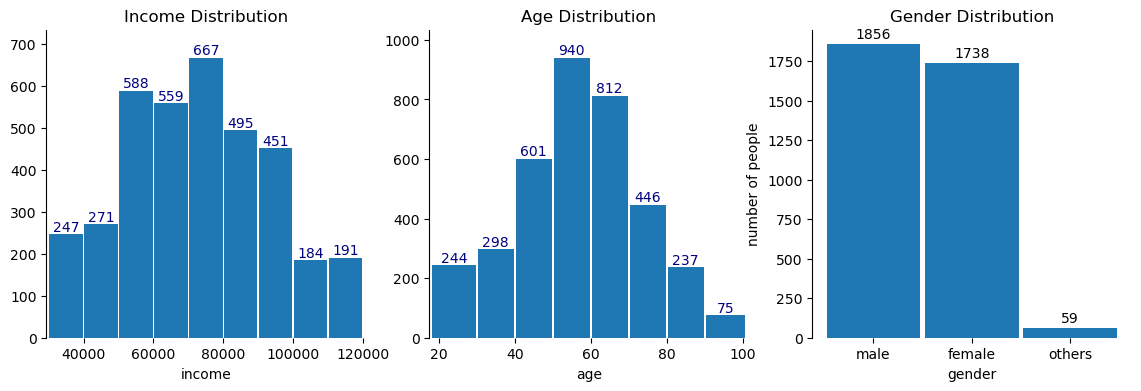

In [240]:
cust_demo(df_f, 1, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 1 have the following attributes,
- Income - 70000 to 80000
- Age - 50-60 years
- Gender - Men have completed more offers than women

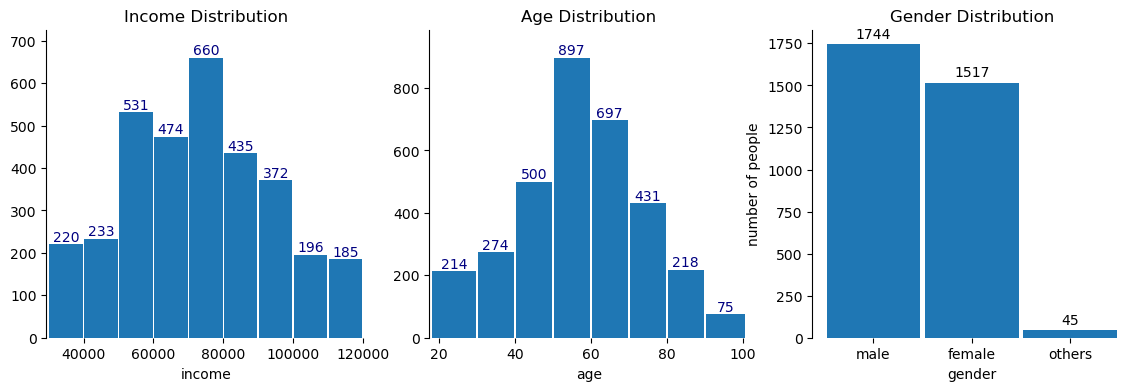

In [241]:
cust_demo(df_f, 2, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 2 have the following attributes,
- Income - 70000 to 80000
- Age - 50-60 years
- Gender - Men have completed more offers than women

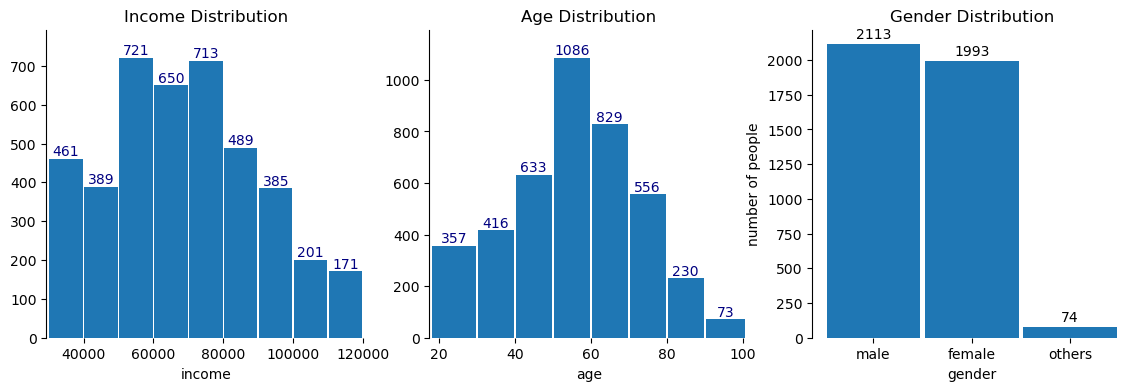

In [242]:
cust_demo(df_f, 3, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 3 have the following attributes,
- Income - 50000 to 60000. But here also 60k to 70k income group is almost equal to 50k to 60k income group.
- Age - 50-60 years
- Gender - Men have completed more offers than women

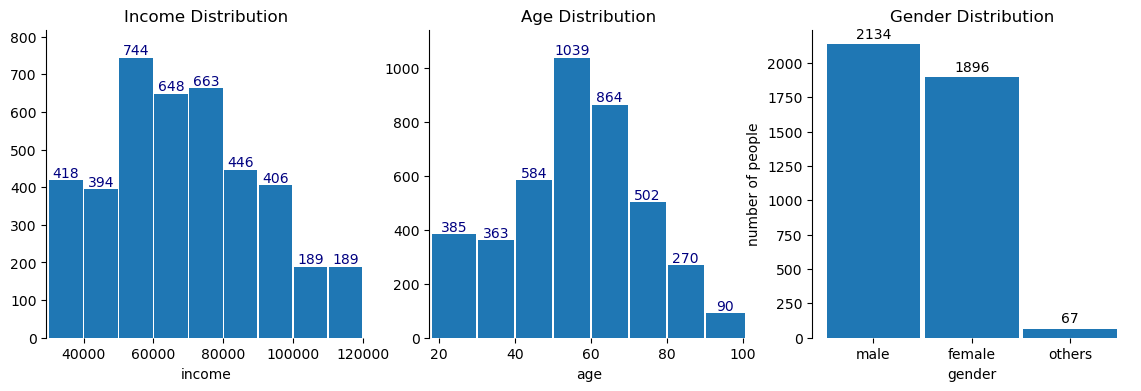

In [243]:
cust_demo(df_f, 4, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 4 have the following attributes,
- Income - 50000 to 60000
- Age - 50-60 years
- Gender - Men have completed more offers than women

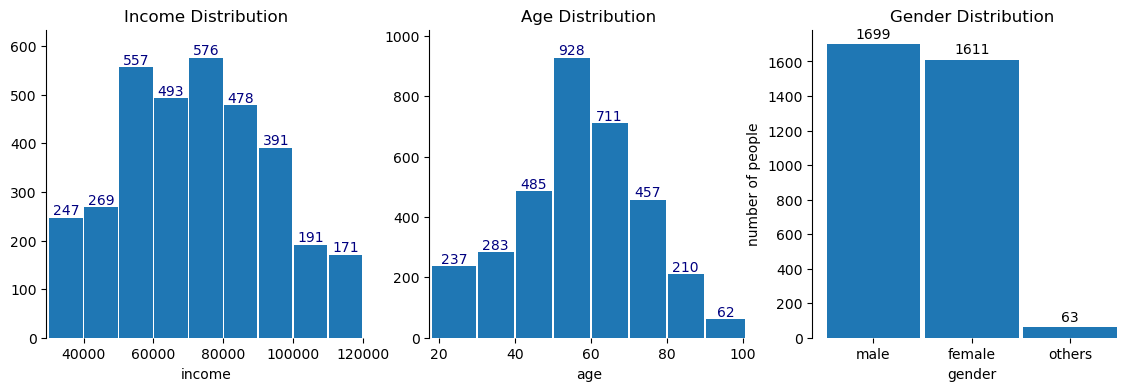

In [244]:
cust_demo(df_f, 5, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 5 have the following attributes,
- Income - 70k to 80k
- Age - 50-60 years
- Gender - Men have completed more offers than women

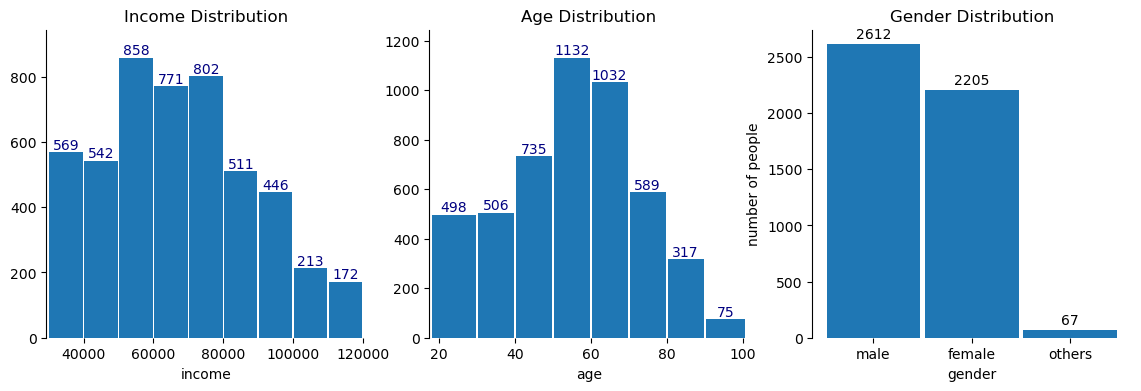

In [245]:
cust_demo(df_f, 6, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 6 have the following attributes,
- Income - 50k to 60k
- Age - 50-60 years
- Gender - Men have completed more offers than women

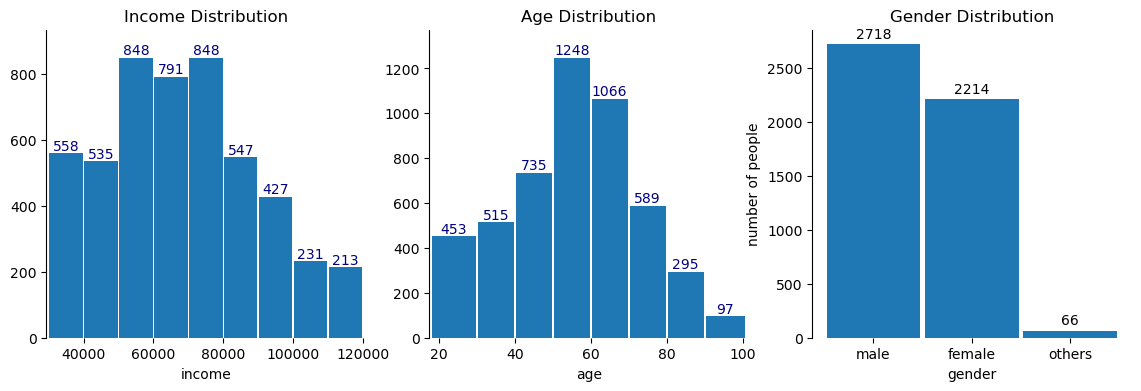

In [246]:
cust_demo(df_f, 7, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 7 have the following attributes,
- Income - 50k to 60k and 70k to 80k income groups have equal number of offer completions
- Age - 50-60 years
- Gender - Men have completed more offers than women

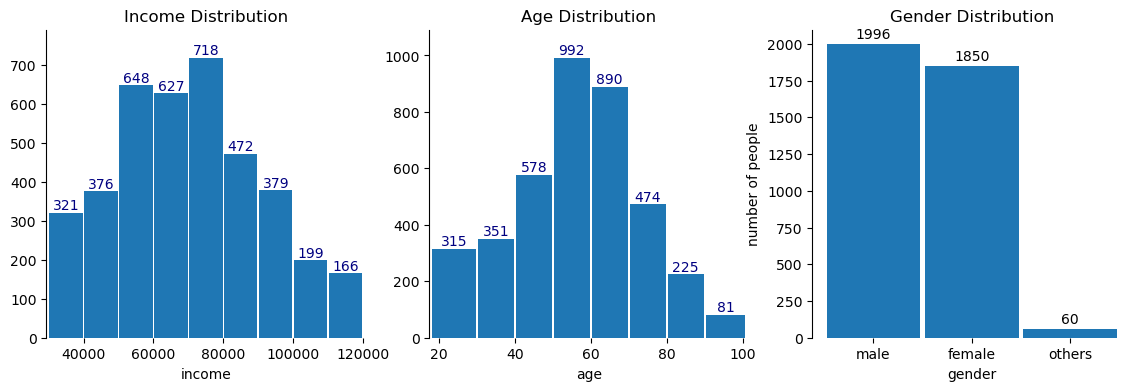

In [247]:
cust_demo(df_f, 8, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 8 have the following attributes,
- Income - 70k to 80k
- Age - 50-60 years
- Gender - Men have completed more offers than women

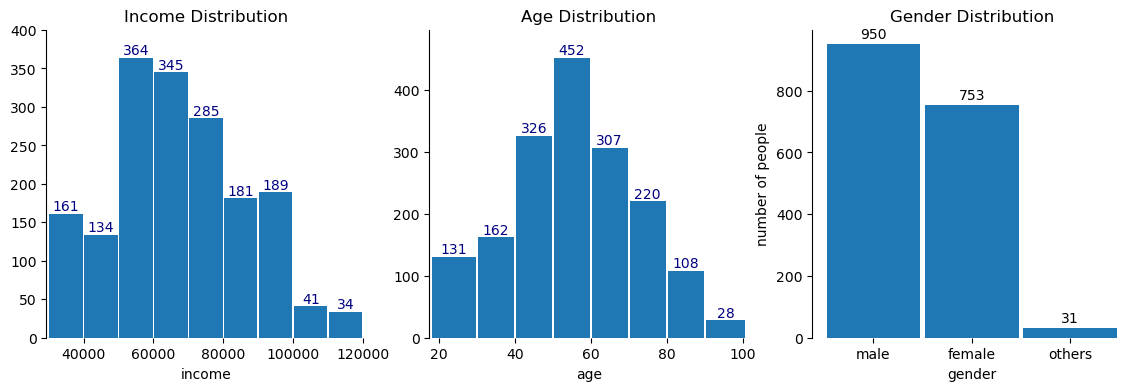

In [248]:
cust_demo(df_f, 9, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 9 have the following attributes,
- Income - 50k to 60k
- Age - 50-60 years
- Gender - Men have completed more offers than women

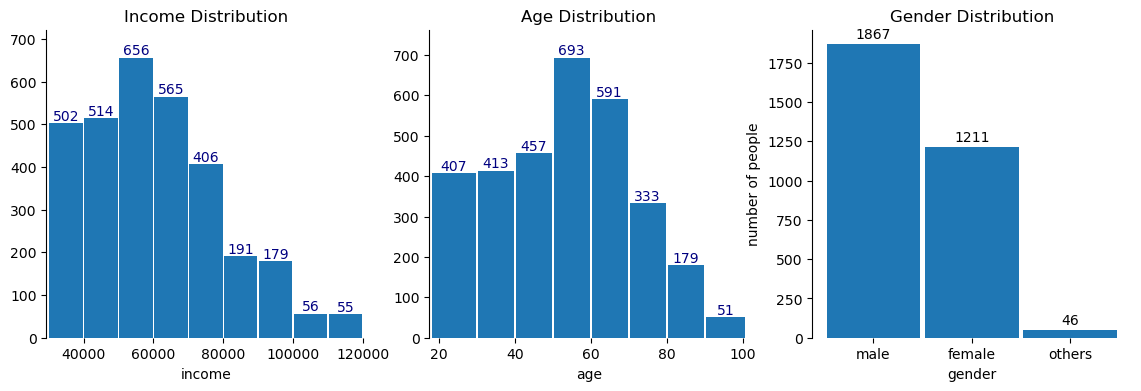

In [249]:
cust_demo(df_f, 10, ['income', 'age', 'gender_id'])

From above we can see that, people who completed the offer 9 have the following attributes,
- Income - 50k to 60k
- Age - 50-60 years
- Gender - Men have completed more offers than women

Based on the above results, the following inferences can be made.

**Income:**
- Among the people who completed different offers, people with income range from 50k to 80k have the most offer completions.
- This pattern is seen in almost all offers.
- Only in 'informational offer 10', people with low income (30k to 60k) have completed more offers than people from 70-80k income group.


**Age:**
- In every offers the people with age range from 50 to 60 years have completed more offers. 
- People with age range of 60 to 70 years have accounted for second highest offer completions. 
- In general, people with age range from 40 to 70 are tend to complete the offers more often than other age groups.


**Gender:**
- In every offer completion, men have more offer completions than women and others. 
- In some offers there are very small gaps between men and women like in offers 8, 5 and 1.

## 2. Which offer has more completion rate in each category

### 2a. Bogo

In [250]:
def bogo_com_rate(df, cols):
    '''
    Deatils: The function plots the 'received to completion rates' and
             'viewed to completion rates' for 'bogo' offers
             
    Inputs:
    df - Dataset from where we retrieve the two columns
    cols - 'received' and 'viewed' columns
    
    Outputs:
    Bar plots of 'received to completion rates' and 'viewed to completion rates'
    of 'bogo' offers
    
    '''
    
    # Empty dictionaries to hold the relevant data for the bogo offers
    rcr_bogo = dict()
    vcr_bogo = dict()
    
    # Empty lists to hold the required data to plot the bar plots
    offer_ids = []
    rate = []
    
    # Iterate through cols variable and collect data for both 'received' and 'viewed' columns
    for col in cols:
        if col == 'received':
            for i in range(1,5):
                
                # calculate 'received to completion rate' for each of the bogo offers
                rcr_bogo[i] = sum(
                    df[df.offer_id == i].completed.loc[(df[df.offer_id == i].completed > 0), ]) / sum(
                    df[df.offer_id == i][col])
                
            # After collecting the rates, append offer ids to 'offer_ids' list
            # and append rates to 'rate' list
            offer_ids.append(["%s"%(x) for x in rcr_bogo.keys()])
            rate.append(list(rcr_bogo.values()))
            
        elif col == 'viewed':
            for i in range(1,5):
                
                # calculate 'viewed to completion rate' for each of the bogo offers 
                vcr_bogo[i] = sum(df[df.offer_id == i].loc[((df[df.offer_id == i].completed > 0) & \
                     (df[df.offer_id == i][col] > 0)),].completed) / sum(
                    df[df.offer_id == i][col].loc[(df[df.offer_id == i][col] > 0), ])

            # After collecting the rates, append offer ids to 'offer_ids' list
            # and append rates to 'rate' list
            offer_ids.append(["%s"%(x) for x in vcr_bogo.keys()])
            rate.append(list(vcr_bogo.values()))
        else:
            pass
            
    # Plot bar plots using the data in both the lists
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    plt.subplots_adjust(hspace=1, wspace=0.8)
    for ax, ids, vals, col in zip(axes.flatten(), offer_ids, rate, cols):
        bar_container = ax.bar(ids, vals, width=0.9)
        ax.set(xlabel='Offer ids',
               ylabel='Rate',
               ylim=(0, max(vals)+0.2))
        ax.set_title('%s to Completion Rate (BOGO)'%(col), pad=20)
        ax.spines[['right', 'top', 'bottom']].set_visible(False) 
        ax.xaxis.set_visible(True)
        ax.bar_label(bar_container, padding=2, fmt='%.2f%%');
        ax.set_xticks(np.arange(len(ids)), ids)

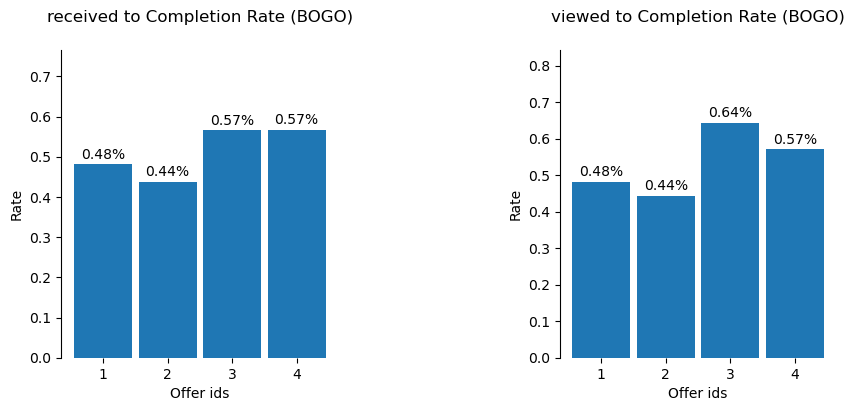

In [251]:
bogo_com_rate(df_f, ['received', 'viewed'])

1. Here we can see that 'offer 3' and 'offer 4' in bogo has highest received to completion rate closely followed by 'offer 1 and offer 2'.


2. In 'viewed to completion rate', offer 3 has maximum number of offer completions leading with a fair margin from the 'offer 4' which has second most offer completions. 'Offers 1 and 2 are in third and last positions respectively.

### 2b. Discount

In [252]:
def discount_com_rate(df, cols):
    
    '''
    Deatils: The function plots the 'received to completion rates' and
             'viewed to completion rates' for 'discount' offers
             
    Inputs:
    df - Dataset from where we retrieve the two columns
    cols - 'received' and 'viewed' columns
    
    Outputs:
    Bar plots of 'received to completion rates' and 'viewed to completion rates'
    of 'discount' offers
    
    '''
    
    # Empty dictionaries to hold the relevant data for the bogo offers
    rcr_dis = dict()
    vcr_dis = dict()
    
    # Empty lists to hold the required data to plot the bar plots
    offer_ids = []
    rate = []
    
    # Iterate through cols variable and collect data for both 'received' and 'viewed' columns
    for col in cols:
        if col == 'received':
            for i in range(5,9):
                
                # calculate 'received to completion rate' for each of the discount offers
                rcr_dis[i] = sum(df_f[df_f.offer_id == i].completed.loc[
                (df_f[df_f.offer_id == i].completed > 0), ]) / sum(df_f[df_f.offer_id == i][col])

            # After collecting the rates, append offer ids to 'offer_ids' list
            # and append rates to 'rate' list
            offer_ids.append(["%s"%(x) for x in rcr_dis.keys()])
            rate.append(list(rcr_dis.values()))
            
        elif col == 'viewed':
            for i in range(5,9):
                
                # calculate 'viewed to completion rate' for each of the bogo offers 
                vcr_dis[i] = sum(df_f[df_f.offer_id == i].loc[
                    ((df_f[df_f.offer_id == i].completed > 0) & \
                     (df_f[df_f.offer_id == i][col] > 0)),].completed) / sum(
                    df_f[df_f.offer_id == i][col].loc[(df_f[df_f.offer_id == i][col] > 0), ])

            # After collecting the rates, append offer ids to 'offer_ids' list
            # and append rates to 'rate' list    
            offer_ids.append(["%s"%(x) for x in vcr_dis.keys()])
            rate.append(list(vcr_dis.values()))
        else:
            pass
            
    # Plot bar plots using the data in both the lists
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    plt.subplots_adjust(hspace=1, wspace=0.8)
    for ax, ids, vals, col in zip(axes.flatten(), offer_ids, rate, cols):
        bar_container = ax.bar(ids, vals, width=0.9)
        ax.set(xlabel='Offer ids',
               ylabel='Rate',
               ylim=(0, max(vals)+0.2))
        ax.set_title('%s to Completion Rate (Discount)'%(col), pad=20)
        ax.spines[['right', 'top', 'bottom']].set_visible(False) 
        ax.xaxis.set_visible(True)
        ax.bar_label(bar_container, padding=2, fmt='%.2f%%');
        ax.set_xticks(np.arange(len(ids)), ids)
            


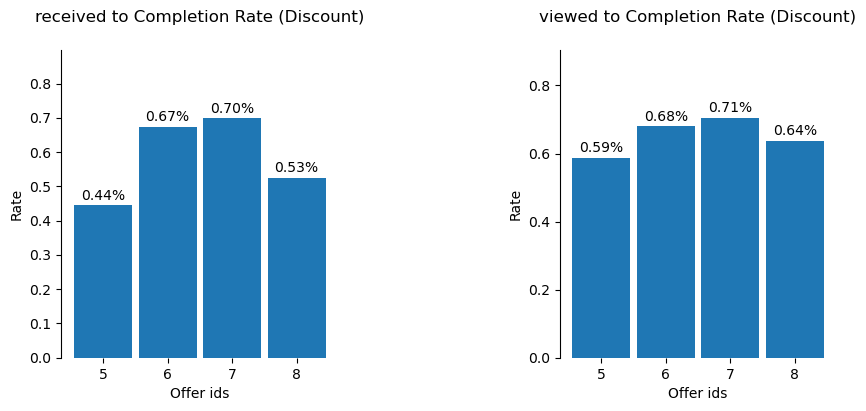

In [253]:
discount_com_rate(df_f, ['received', 'viewed'])

1. Here we can see that 'offer 7' in discount offers has highest received to completion rate closely followed by 'offer 6'. Offers 8 and 5 are in third and last positions respectively.


2. In 'viewed to completion rate', again 'offer 7' has maximum number of offer completions leading with a liitle margin from the 'offer 6' which has second most offer completions. 'Offers 8 and 5 are in third and last positions respectively.

### 1c. Informational

#### Received to Completion Ratio and View to Completion Ratio


Because both are same as I have considered the offer completion only when a customer views the offer and to view the offer the customer has to receive it first. Hence both are same.

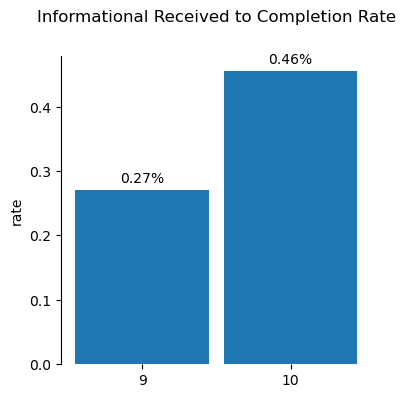

In [254]:
# Create an empty dictionary to hold the 'viewed to completion rate' of 
# informational offers
cr_info = dict()

# Calculate the 'viewed to completion rate' and store it in the empty dictionary
for i in range(9,11):
    cr_info[i] = sum(df_f[df_f.offer_id == i].transaction) / sum(df_f[df_f.offer_id == i].received)
    
# store the data labels in 'offer_ids4'
offer_ids4 = ["%s"%(x) for x in cr_info.keys()]

# store the data values in 'rate4'
rate4 = list(cr_info.values())

# numpy array to help labelling the plot
x4 = np.arange(len(offer_ids4))

# Plot bar chart for 'viewed to completion rate'
fig, ax = plt.subplots(figsize=(4,4))
bar_container = ax.bar(offer_ids4, rate4, width=0.9)
ax.set(ylabel='rate')
ax.set_title('Informational Viewed to Completion Rate', pad=25)
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(True)
ax.bar_label(bar_container, padding=3, fmt='%.2f%%');
ax.set_xticks(x4, offer_ids4);

In cas of informational offers, 'offer 10' has highest viewed to completion rate of 59% and 'offer 9' has 39% viewed to completion rate.

## 2. Gender Preferences

### 2a. Out of total offer completions how many are men, women and others

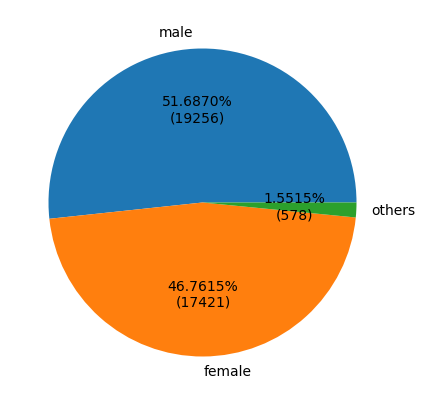

In [255]:
# Extracting the gender id data when the offers are completed
gen_pref1 = df_f[df_f.completed == 1].gender_id
gen_pref1 = gen_pref1.loc[gen_pref1.notna()]

# Extract the lables and values of each gender to plot a pie chart
lab_gen_pref1 = ['male', 'female', 'others']
val_gen_pref1 = list(gen_pref1.value_counts())

def my_fmt(x):
    return '{:.4f}%\n({:.0f})'.format(x, sum(val_gen_pref1)*x/100)

# Plot a pie chart
fig, ax = plt.subplots(figsize=(5,5));
ax.pie(val_gen_pref1, labels=lab_gen_pref1, autopct=my_fmt);

Out of total offer completions, the highest percentage is of men with 51.69%, followed by women with 46.76% and others with 1.55%.

### 2b. Completion rate of each gender

In [256]:
# Male completion rate
male_com_rate = len(df_f.loc[(df_f.gender_id == 1) & \
                             (df_f.completed == 1)])*100 / len(df_f.loc[(df_f.gender_id == 1)])

In [257]:
# Female completion rate
female_com_rate = len(df_f.loc[(df_f.gender_id == 2) & \
                               (df_f.completed == 1)])*100 / len(df_f.loc[df_f.gender_id == 2])

In [258]:
# Others completion rate
others_com_rate = len(df_f.loc[(df_f.gender_id == 3) & \
                               (df_f.completed == 1)])*100 / len(df_f.loc[df_f.gender_id == 3])

In [259]:
# data labels and data values
gens = ['Male', 'Female', 'Others']
com_rates = [male_com_rate, female_com_rate, others_com_rate]

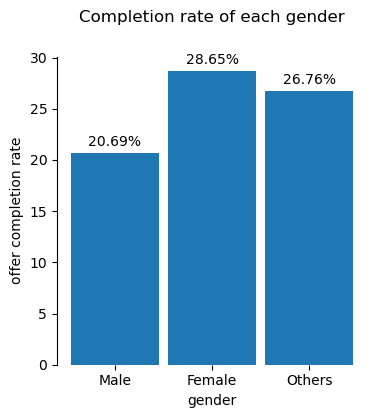

In [260]:
# Plot the bar chart for offer completion of each gender
fig, ax = plt.subplots(figsize=(4,4))
bar_container = ax.bar(gens, com_rates, width=0.9)
ax.set(xlabel='gender', ylabel='offer completion rate')
ax.set_title('Completion rate of each gender', pad=25)
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(True)
ax.bar_label(bar_container, padding=3, fmt='%.2f%%');
ax.set_xticks(np.arange(len(gens)), gens);

### 2c. Portion of each gender where the offer is viewed but not completed

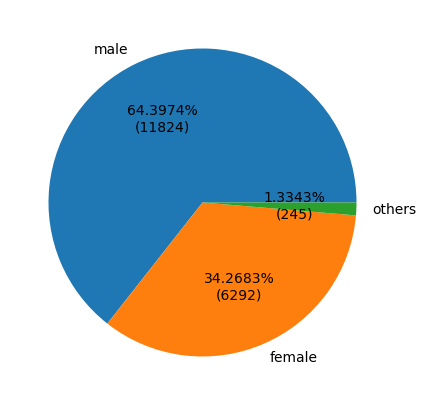

In [261]:
# Extracting the gender id data when the offers are viewed but not completed
gen_pref2 = df_f.loc[(df_f.viewed == 1) & (df_f.completed == 0), ].gender_id
gen_pref2 = gen_pref2.loc[gen_pref2.notna()]

# Extract the lables and values of each gender to plot a pie chart
lab_gen_pref2 = ['male', 'female', 'others']
val_gen_pref2 = list(gen_pref2.value_counts())

def my_fmt(x):
    return '{:.4f}%\n({:.0f})'.format(x, sum(val_gen_pref2)*x/100)

# Plot a pie chart
fig, ax = plt.subplots(figsize=(5,5));
ax.pie(val_gen_pref2, labels=lab_gen_pref2, autopct=my_fmt);

In instances such as when offer is received and viewed but not completed, men have msot number of such instances with 64.40% followed by women with only 34.27% and others with 1.33%

### 2d. Percentage of offers which were viewed but not completed in each gender category

In [262]:
# male offer ignoring rate
male_vie_rate = len(df_f.loc[(df_f.viewed == 1) & (df_f.completed == 0) & \
                        (df_f.gender_id == 1)])*100 / len(df_f.loc[(df_f.viewed == 1) & \
                                                              (df_f.gender_id == 1)])

In [263]:
# female offer ignoring rate
female_vie_rate = len(df_f.loc[(df_f.viewed == 1) & (df_f.completed == 0) & \
                        (df_f.gender_id == 2)])*100 / len(df_f.loc[(df_f.viewed == 1) & \
                                                              (df_f.gender_id == 2)])

In [264]:
# others offer ignoring rate
others_vie_rate = len(df_f.loc[(df_f.viewed == 1) & (df_f.completed == 0) & \
                        (df_f.gender_id == 3)])*100 / len(df_f.loc[(df_f.viewed == 1) & \
                                                              (df_f.gender_id == 3)])

In [265]:
# data values for each gender
vie_rates = [male_vie_rate, female_vie_rate, others_vie_rate]

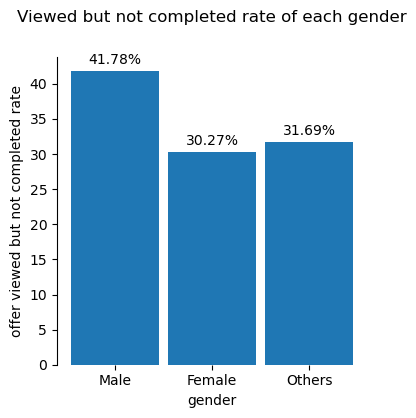

In [266]:
# Plot the bar plot for offer ignoring rate of each gender category
fig, ax = plt.subplots(figsize=(4,4))
bar_container = ax.bar(gens, vie_rates, width=0.9)
ax.set(xlabel='gender', ylabel='offer viewed but not completed rate')
ax.set_title('Viewed but not completed rate of each gender', pad=25)
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(True)
ax.bar_label(bar_container, padding=3, fmt='%.2f%%');
ax.set_xticks(np.arange(len(gens)), gens);

### 2e. Portion of each gender where the offer is received but not viewed and completed

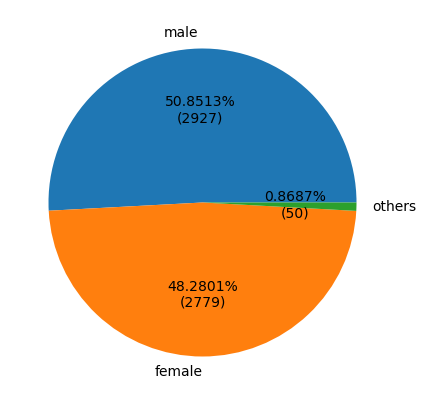

In [267]:
# Extracting the gender id data when the offers are received but not viewed and completed
gen_pref3 = df_f.loc[(df_f.received == 1) & \
                     (df_f.viewed == 0) & \
                     (df_f.completed == 1)].gender_id
gen_pref3 = gen_pref3.loc[gen_pref3.notna()]

# Extract the lables and values of each gender to plot a pie chart
lab_gen_pref3 = ['male', 'female', 'others']
val_gen_pref3 = list(gen_pref3.value_counts())

def my_fmt(x):
    return '{:.4f}%\n({:.0f})'.format(x, sum(val_gen_pref3)*x/100)

# Plot a pie chart
fig, ax = plt.subplots(figsize=(5,5));
ax.pie(val_gen_pref3, labels=lab_gen_pref3, autopct=my_fmt);

In another instance where the offers is received and completed unknowingly without viewing the offer, the men again have highest number of such transactions with 50.85% followed by women with 48.28% and others with 0.86%.

### 2f. Gender distribution while completed the offers unknowilngly

In [268]:
# male unknown completion rate
male_unk_rate = len(df_f.loc[(df_f.viewed == 0) & (df_f.completed == 1) & \
                        (df_f.gender_id == 1)])*100 / len(df_f.loc[(df_f.completed == 1) & \
                                                              (df_f.gender_id == 1)])

In [269]:
# female unknown completion rate
female_unk_rate = len(df_f.loc[(df_f.viewed == 0) & (df_f.completed == 1) & \
                        (df_f.gender_id == 2)])*100 / len(df_f.loc[(df_f.completed == 1) & \
                                                              (df_f.gender_id == 2)])

In [270]:
# others unknown completion rate
others_unk_rate = len(df_f.loc[(df_f.viewed == 0) & (df_f.completed == 1) & \
                        (df_f.gender_id == 3)])*100 / len(df_f.loc[(df_f.completed == 1) & \
                                                              (df_f.gender_id == 3)])

In [271]:
# Data values for unknown offer completion rate of each gender
unk_rates = [male_unk_rate, female_unk_rate, others_unk_rate]

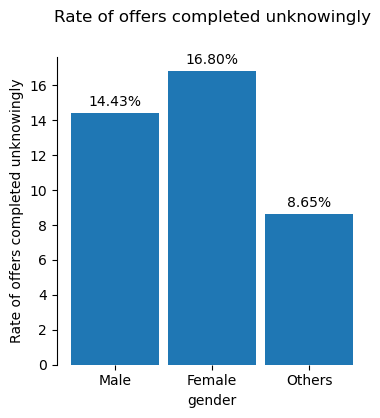

In [272]:
# Plotting the bar plot of unknown offer completion rate of each gender
fig, ax = plt.subplots(figsize=(4,4))
bar_container = ax.bar(gens, unk_rates, width=0.9)
ax.set(xlabel='gender', ylabel='Rate of offers completed unknowingly')
ax.set_title('Rate of offers completed unknowingly', pad=25)
ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(True)
ax.bar_label(bar_container, padding=3, fmt='%.2f%%');
ax.set_xticks(np.arange(len(gens)), gens);

### 2e. Gender wise offer preferences

In [273]:
def gen_pref(gender_id, genders, df=df_f):
    
    '''
    Details: The function plots the number of offer completions for each gender
    
    Input:
    gender_id - Genders in encoded format i.e., 1 for male and 2 for female
    genders - Actual genders, male and female
    df(default argument) - The dataframe from where we take gender column
    
    Output:
    Offer completions for each gender in descending order
    
    '''
    # Empty lists to hold data labels and data values to plot bar chart
    labels = []
    vals = []
    
    # Go through both genders and extract offer completions of different offers
    # and append the data labels and values to respective lists
    for i in gender_id:
        off_pref = df_f.loc[(df_f.gender_id == i)]
        labels.append(["%s"%(x) for x in \
                       list(off_pref.loc[off_pref.completed == 1].offer_id.value_counts().index)])
        vals.append(list(
            off_pref.loc[off_pref.completed == 1].offer_id.value_counts().values))
    
    # PLot the horizontal bar chart for both males and females
    fig, axes = plt.subplots(1,3, figsize=(17,6))
    plt.subplots_adjust(hspace=0.8)
    
    for ax, label, val, gender in zip(axes.flatten(), labels, vals, genders):
        x = np.arange(len(label))
        hbars = ax.barh(label, val, align='center')
        ax.set_yticks(x, labels=label)
        ax.invert_yaxis()
        ax.set_xlabel(gender)
        ax.set_title('Offer Preferences of %s'%(gender))
        ax.bar_label(hbars, fmt='%.1f', padding=5)
        ax.spines[['right', 'top', 'bottom']].set_visible(False); 
        ax.xaxis.set_visible(True);


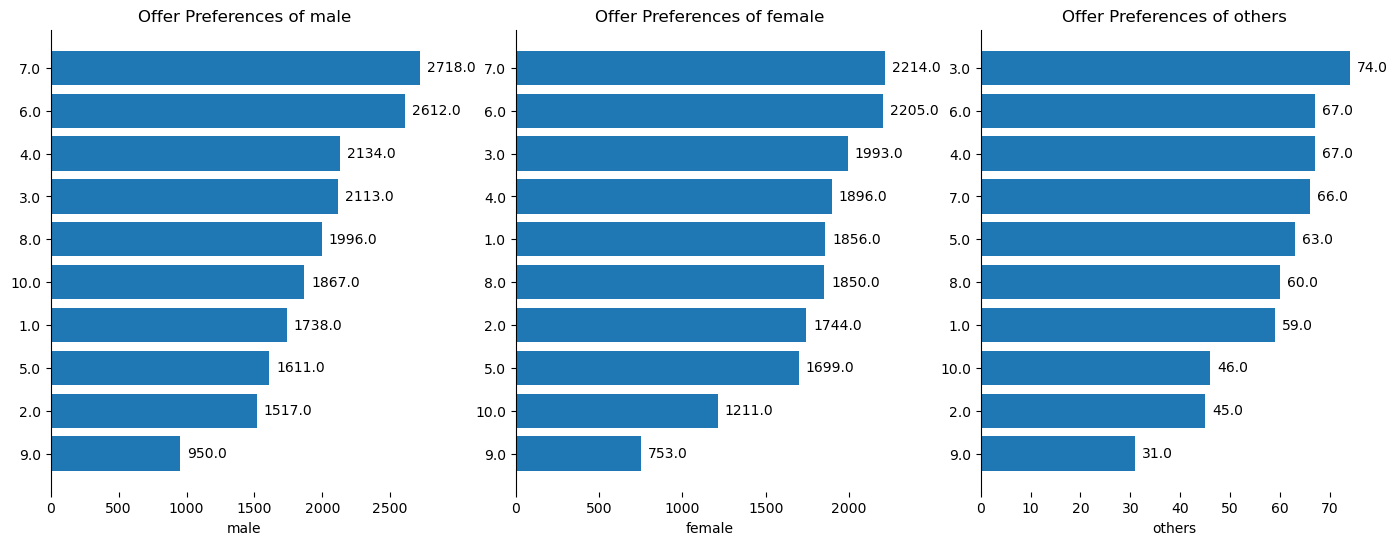

In [274]:
gen_pref([1,2,3], ['male', 'female', 'others'])

1. Men prefer 'discount offer id 7' the most followed by 'discount offer id 6' and 'bogo offer id 4'. The least preferred offer id by men is 'informational offer id 9' and 'bogo offer 2'. 


2. Women prefer 'discount offer id 7' the most followed by 'discount offer id 6' and 'bogo offer id 3'. The least preferred by women is 'informational offer id 9' and 'informational offer 10'.


In general, we can say that the top most preferred offers by both men and women are '7, 6, 3 and 4'.

## 3. Offer Preferences based on Income

### Offer preferences based on income categories

In [275]:
def plot_inc_cats(income_cats, df=df_f):
    '''
    Details: The function plots the number of offer completions for each
             income category
    
    Input:
    income_cats - Income ranges based on minimum and maximum incomes
    df(default argument) - The dataframe from where we take income column
    
    Output:
    Offer completions for each income category in descending order 
    
    '''
    
    # Empty lists to hold data labels and data values to plot bar chart
    ids = []
    rates = []
    
    # Go through income categories and extract offer completions of different offers
    # and append the data labels and values to respective lists
    for i, j in income_cats.items():
        inc = df.loc[(df.income >= i) & (df.income < j)] 
        
        ids.append(["%s"%(x) for x in list(inc.loc[inc.completed == 1].offer_id.value_counts().index)])
        rates.append(list(inc.loc[inc.completed == 1].offer_id.value_counts().values))
        
    # PLot the bar chart for all the income categories
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,8));
    plt.subplots_adjust(hspace=0.8)

    for ax, i, rate, j, k in zip([ax1, ax2, ax3], ids, rates, income_cats.keys(), income_cats.values()):
        bar_container = ax.bar(i, rate, width=0.9)
        ax.set(xlabel='income',
               ylabel='Offer Completions')
        ax.set_title('income range %s - %s'%(j, k), pad=20);
        ax.spines[['right', 'top', 'bottom']].set_visible(False); 
        ax.xaxis.set_visible(True);
        ax.bar_label(bar_container, padding=2);
        ax.set_xticks(np.arange(len(i)), i);


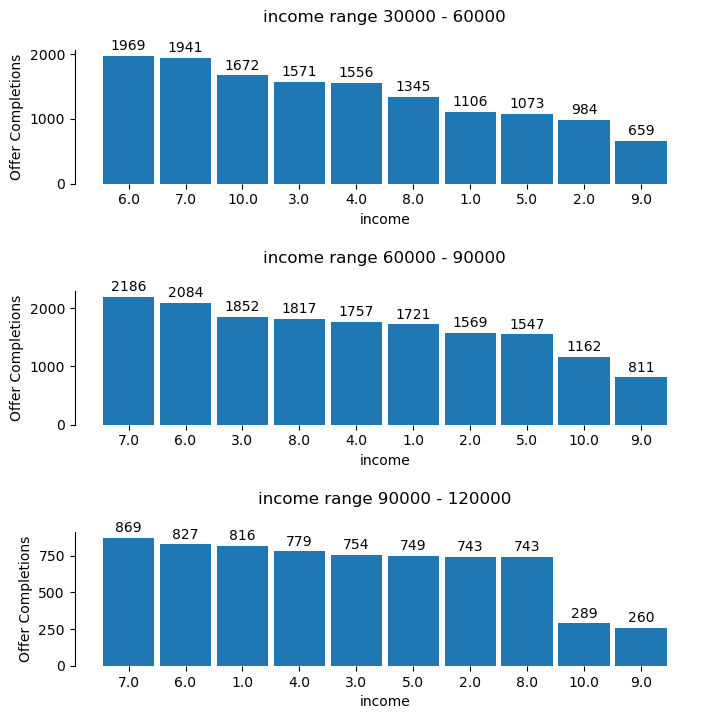

In [276]:
# Income categories
inc_cats = {30000:60000,
           60000:90000,
           90000:120000}
plot_inc_cats(inc_cats)

1. People with small income range 30k-60k prefer 'discount offer id 6' the most. 'Discount offer 7 and informational offer 10 are at the 2nd and 3rd position. There is a very close margin between offer ids 6 and 7. The least preferred offers are offer ids '9, 2, and 5'.


2. People with mid income range 60k-90k prefer 'discount offer id 7' the most followed by 'discount offer id 6' and 'bogo offer id 3'. The least preferred offer ids by these people are 'informational offers 9 and 10'.


3. People with high income range 90k-120k prefer 'discount offer id 7' the most followed by 'discount offer id 6 and bogo offer id 1'. Here also, there is not much difference between the top 3 most preferred offers. The least preferred offers by these people are 'informational offers 9 and 10'.

## 4. Offer Preferences based on Age

In [277]:
def plot_age_cats(age_categories, df=df_f):
    
    '''
    Details: The function plots the number of offer completions for each
             age category
    
    Input:
    age_categories - Age ranges based on minimum and maximum age
    df(default argument) - The dataframe from where we take age column
    
    Output:
    Offer completions for each age category in descending order 
    
    '''
    
    # Empty lists to hold data labels and data values to plot bar chart
    ages = []
    vals = []
    
    # Go through age ranges and extract offer completions of different offers
    # and append the data labels and values to respective lists
    for i, j in age_categories.items():
        age_df = df.loc[(df.age >= i) & (df.age < j)] 
        
        ages.append(["%s"%(x) for x in list(age_df.loc[age_df.completed == 1].offer_id.value_counts().index)])
        vals.append(list(age_df.loc[age_df.completed == 1].offer_id.value_counts().values))
        
    # PLot the bar chart for both age categories
    fig, axes = plt.subplots(2,2, figsize=(13,8));
    plt.subplots_adjust(hspace=0.8)

    for ax, age, val, j, k in zip(axes.flatten(), ages, vals, age_categories.keys(), 
                                  age_categories.values()):
        bar_container = ax.bar(age, val, width=0.9)
        ax.set(xlabel='Age',
               ylabel='Offer Completions')
        ax.set_title('Age range %s - %s'%(j, k), pad=20);
        ax.spines[['right', 'top', 'bottom']].set_visible(False); 
        ax.xaxis.set_visible(True);
        ax.bar_label(bar_container, padding=2);
        ax.set_xticks(np.arange(len(age)), age);


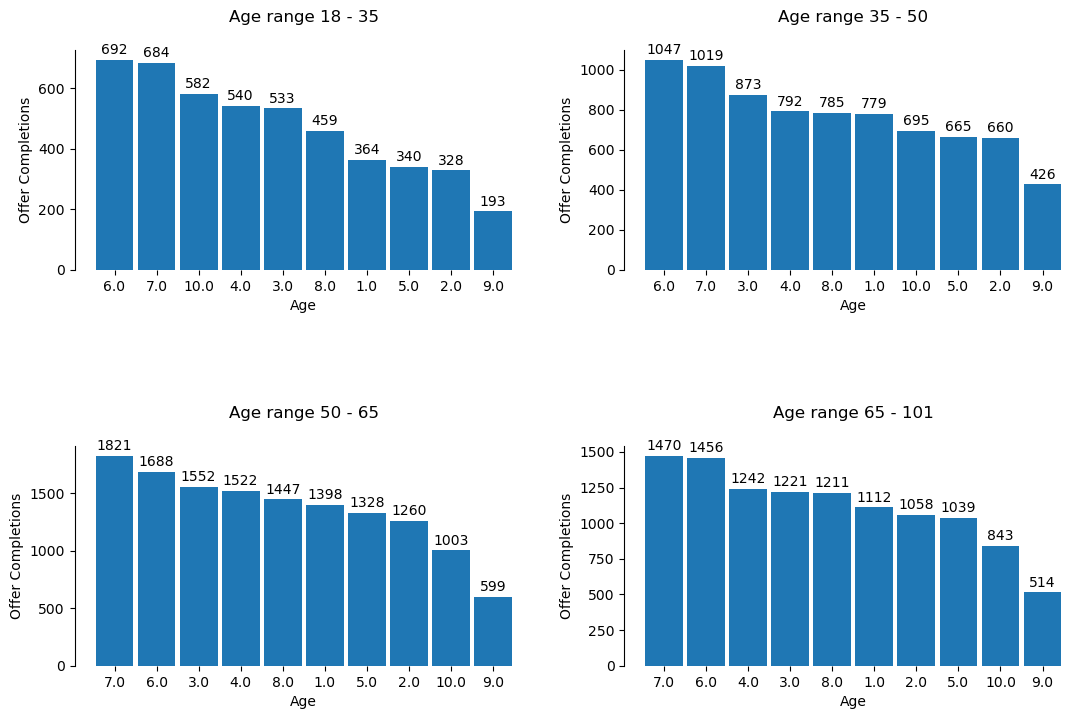

In [451]:
# age categories
age_cats = {18:35,
           35:50,
           50:65,
           65:101}
plot_age_cats(age_cats)

1. On a general note we can notice that 'discount offers 6 and 7' are the most preferred offers in all the categories and we can see that the 3rd most preferred offer is different apart from the top 2 offers.


2. In the age range of 18 to 35 (younger customers) the most preferred offer is 'discount offer with id 6' closely followed by 'discount offer with id 7'. The third most preferred offer is 'informational offer with id 10'. The least preferred offers are offers with id '9' and '2'.


3. In the age range of 35 to 50 (lower middle aged customers) the most preferred offer is 'discount offer with id 6' closely followed by 'discount offer with id 7'. The third most preferred offer is 'bogo offer with id 3'. The least preferred offers are offers with offer ids '2' and '9'.


4. In the age range of 50 to 70 (upper middle aged customers), the most preferrd offer is 'discount offer with id 7' followed by 'discount offer with id 6'. The third most preferred offer is 'bogo offer with id 3'. The least preferred offers are informational offers '9' and '10'.


5. In the age range of 70 to 100 (old people), the most preferred offer is 'offer id 6' followed by 'offer id 7'. The third most preferred offer is 'offer id 3'. The least preferred offers are informational offers '9' and '10'.

## 6. Correlation Map

In [284]:
# Convert train_set dataframe from 'object' datatype to 'float64' datatype
for col in df_f.columns:
    df_f[col] = df_f[col].astype(float)

# Correlation table to see the correlation coefficients of independent variables
# with target variable
cor_mat = df_f.corr()
cor_mat['completed'].sort_values(ascending=False)

completed           1.000000
completed_time      0.876107
reward              0.760795
enc_email           0.613187
received            0.613187
duration            0.599156
dur_hours           0.599156
viewed              0.595654
enc_mobile          0.575461
expr                0.559040
enc_web             0.530773
received_time       0.496136
viewed_time         0.494918
offer_id            0.489523
enc_social          0.473666
difficulty          0.469769
discount            0.403378
bogo                0.323560
transaction         0.270381
transaction_time    0.205506
income              0.176817
amount              0.173389
inform              0.107072
gender_id           0.087437
age                 0.084613
memb_yrs            0.008759
person_id          -0.002088
Name: completed, dtype: float64

In [452]:
# Enhancing the column names so that they are visible clearly
fig, ax = plt.subplots(figsize=(25, 15))
ax = sns.heatmap(cor_mat, cmap= 'coolwarm', annot=True);

for i, j in zip(ax.get_xticklabels(), ax.texts):
    text =  i.get_text()
    if text in list(df_f.columns): # lets highlight rows
        # set the properties of the ticklabel
        i.set_weight('bold')
        i.set_size(20)
        i.set_color('purple')
        # set the properties of the heatmap annot
        j.set_weight('bold')
        j.set_color('purple')
for i, j in zip(ax.get_yticklabels(), ax.texts):
    text =  i.get_text()
    if text in list(df_f.columns): # lets highlight rows
        # set the properties of the ticklabel
        i.set_weight('bold')
        i.set_size(20)
        i.set_color('purple')
        # set the properties of the heatmap annot
        j.set_weight('bold')
        j.set_color('purple')

Error in callback <function flush_figures at 0x0000016E54C3D940> (for post_execute):


KeyboardInterrupt: 

## Data Cleaning

## Split the data into training and test set

We will exclude the details regarding the offer which are observed after the offer is completed, because we want to predict whether the person will complete the offer or not and for that we only will have the offer details which are prior to the offer completion. Hence using the details which are observed after the offer is completed is pointless as we can observe data leakage regarding offer completion. This can lead to a bias in the anlysis and the model will always performs better. Hence we will leave out the details which are observed after the offer is completed.

In [286]:
# Dropping the columns which have the offer details observed after the offer is completed 
df_f.drop(['completed_time', 'transaction', 'transaction_time', 'amount', 'reward', 'dur_hours'], axis=1, inplace=True)

In [287]:
# Convert the data types of all columns in the main dataset to floating point data type
for col in df_f.columns:
    df_f[col] = df_f[col].astype(float)

In [288]:
# Create training set and testing set
train, test = train_test_split(df_f, test_size=0.3, random_state=23)

In [289]:
# Creating training set and validation set
X_train, X_val, y_train, y_val = train_test_split(train.drop('completed', axis=1), train.completed.copy(),
                                                  test_size=0.1, random_state=12)

### Missing Data Handling

There are several ways to handle the missing data.

1. We can delete the entire row/column when more than half of the row/column has missing values. If you think there are some missing values which are very important and considered as important data loss with respect to predicting the target variable, then we can delete that entire row. 

2. Another way to handle the missing values is to impute them using some appropriate methods like imputing with mediam value, filling the null value with previous values or with next value or with a constant value.

In [208]:
X_train.isna().sum()[5:6][0]/X_train.shape[0]

0.12911574152035382

We can see that more than 12% of our data is missing in the columns 'gender_id', 'age', and 'income'. We can say generally that these demographic features of a person are important in predicting our target variable, but unfortunately, we can see in the correlation plot above that these features have least positive correlation with our target variable. 


According to statistical studies, if more than 10% of data is missing, then there is a chance of likely bais in the analysis. As there is a significant portion of the data is missing, we can go with imputation method to impute the null values with some aggregate number

### Handling the Categorical Variables

We have only one categorical variable which is 'gender_id' at this moment. We will create dummy variables of 'gender_id' column.

In [211]:
def data_cleaning(X):
    '''
    Details: The function cleans the input data by impting the missing values
             and creating dummy variables of the categorical variables
             
    Input:
    X - A dataframe (either train or test)
    
    Output:
    X - A cleaned dataframe
    
    '''
    
    # As 'gender_id' is a categorical variable, we can't use median or aggregate value imputation
    # method. Hence we go with 'backward fill' method.
    X.gender_id = X.gender_id.fillna(method='bfill')
    
    # We can impute all the null values in the numerical variables with median values
    X.income.fillna(X.income.median(), inplace=True)
    X.age.fillna(np.ceil(X.age.median()), inplace=True)
    
    # Creating dummy variables of the gender_id column
    X = pd.get_dummies(X, columns=['gender_id'])
    X.rename(columns={'gender_id_1.0':'male',
                      'gender_id_2.0':'female',
                      'gender_id_3.0':'others'}, inplace=True)
    
    return X

In [292]:
# Clean the training data
X_train = data_cleaning(X_train)

In [297]:
# Clean the validation  
X_val = data_cleaning(X_val)

## Data Scaling

In [121]:
df_f['completed'].value_counts()/df_f.shape[0]

0.0    0.781898
1.0    0.218102
Name: completed, dtype: float64

We will use 'standardization' scaling method to scale the data. Then a 'pipeline' is created in which the data will be over-sampled and under-sampled. Then we will scale the data using 'StandardScaler' function.

In [300]:
def data_prep(X, y):
    '''
    Details: The input data will be over-sampled, under sampled and 
             scaled down
    
    Inputs:
    X - Input/independent variables which are used to feed into the ML algorithms
    y - Target variable
    
    Outputs:
    X_scl - The independent data which has been over-sampled, under-sampled and 
            scaled down
    y - Target variable which also has been under-sampled and over-sampled
    '''
    
    # Scaling down the data using standardscalar
    std_scal = StandardScaler()
    X_scl = std_scal.fit_transform(X)
    
    return X_scl, y

In [301]:
X_train_scl, y_train = data_prep(X_train, y_train)

In [303]:
len(X_train_scl), len(y_train)

(112829, 112829)

## Test Different Classification Algorithms with Default Settings

The algorithms used for the purpose of predicting on the test set are
1. 

In [304]:
# Instantiating different classification algorithms
log_clf = LogisticRegression(random_state=12, max_iter=150)
tree_clf = DecisionTreeClassifier(random_state=12)
forest_clf = RandomForestClassifier(random_state=12)
svm_clf = svm.SVC(probability=False)
sdg_clf = SGDClassifier(random_state=12)

In [305]:
clf_lst = [log_clf, tree_clf, forest_clf, svm_clf, sdg_clf]

In [306]:
def clf_pred(X, y, clf):
    '''
    Details: The scaled input data is used to cross-validate the performance 
             of the classifier
             
    Inputs:
    X: Input/independent variables which are used to feed into the ML algorithms
    y - Target variable
    
    Output:
    The output of the function is printing the mean scores of 'f1', 'recall' and 
    'precision'
    
    '''
    # cross-validation of the different classifiers
    y_train_pred = cross_val_predict(clf, X, y, cv=5)
    
    print("precision score is %s"%(precision_score(y, y_train_pred)))
    print("recall score is %s"%(recall_score(y, y_train_pred)))
    print("f1 score is %s"%(f1_score(y, y_train_pred)))

In [307]:
s = time.time()
# Printing the mean scores of f1, recall and precision of different classifiers
for clf in clf_lst:
    print()
    print(clf)
    clf_pred(X_train_scl, y_train, clf)
    print(time.time() - s)
    print()


LogisticRegression(max_iter=150, random_state=12)
precision score is 0.6623225956146797
recall score is 0.6978648846874745
f1 score is 0.6796293724330866
7.146656036376953


DecisionTreeClassifier(random_state=12)
precision score is 0.6994687372292603
recall score is 0.6974166734577459
f1 score is 0.698441198073941
9.41457200050354


RandomForestClassifier(random_state=12)
precision score is 0.7464093892977919
recall score is 0.7644446255398908
f1 score is 0.7553193630855325
50.233612060546875


SVC()
precision score is 0.7206417530815887
recall score is 0.7503870915165838
f1 score is 0.7352136854502266
1524.7499310970306


SGDClassifier(random_state=12)
precision score is 0.677669818686562
recall score is 0.636582185640942
f1 score is 0.6564837381292545
1528.4193723201752



## Using Ensemble Classifier

The main theme of the ensemble learning is that 'aggregation of predictions by individual classifiers is better than predictions from an individual classifier.'

From above cross-validation scores, we can select 3 classifiers and use them in ensemble learning. As we care slightly more about 'recall' than 'precision', we can select 'random forest classifier', 'decision tree' and 'logistic regression'.

In [308]:
vote_clf = VotingClassifier(estimators=[('rf', forest_clf), ('tree', tree_clf), ('log', log_clf)],
                           voting='soft', n_jobs=-1)

In [309]:
s = time.time()
clf_pred(X_train_scl, y_train, vote_clf)
print(time.time() - s)

precision score is 0.7146383908697236
recall score is 0.7195012631407384
f1 score is 0.7170615825059391
103.53043818473816


## Handling the Data Imbalance

In [ ]:
df_f['completed'].value_counts()/df_f.shape[0]

From above, we can observe that the target classes distribution is moderately imbalanced (minority class between 20-40% denotes moderate imbalance). Hence 'a combination of undersampling and oversampling' is used to reduce the imbalnce in the dataset. For over-sampling we will use 'SMOTE' and for under-sampling we will use 'RandomUnderSampler'.

In [310]:
def data_prep1(X, y):
    '''
    Details: The input data will be over-sampled, under sampled and 
             scaled down
    
    Inputs:
    X - Input/independent variables which are used to feed into the ML algorithms
    y - Target variable
    
    Outputs:
    X_scl - The independent data which has been over-sampled, under-sampled and 
            scaled down
    y - Target variable which also has been under-sampled and over-sampled
    '''
    
    
    # Create instances of 'unsdersampling' and 'SMOTE'
    over_sam = SMOTE(sampling_strategy=0.3, random_state=12)
    under_sam = RandomUnderSampler(sampling_strategy=0.5)
    
    # Creating pipeline which include both under and over sampling
    pipe = Pipeline(steps=[('over', over_sam), ('under', under_sam)])
    X, y = pipe.fit_resample(X, y)
    
    # Scaling down the data using standardscalar
    std_scal = StandardScaler()
    X_scl = std_scal.fit_transform(X)
    
    return X_scl, y

In [313]:
X_train_scl, y_train = data_prep1(X_train, y_train)

In [314]:
len(X_train_scl), len(y_train)

(79458, 79458)

In [315]:
s = time.time()
# Printing the mean scores of f1, recall and precision of different classifiers
for clf in clf_lst:
    print()
    print(clf)
    clf_pred(X_train_scl, y_train, clf)
    print(time.time() - s)
    print()


LogisticRegression(max_iter=150, random_state=12)
precision score is 0.737353712348916
recall score is 0.870648644566941
f1 score is 0.7984764542936289
4.281973361968994


DecisionTreeClassifier(random_state=12)
precision score is 0.786707410236822
recall score is 0.7776183644189383
f1 score is 0.7821364827402878
6.132729530334473


RandomForestClassifier(random_state=12)
precision score is 0.8025598564824398
recall score is 0.8783130710564072
f1 score is 0.8387294490914335
33.6697735786438


SVC()
precision score is 0.7467899957402787
recall score is 0.9266782451106245
f1 score is 0.8270656422698477
734.1134266853333


SGDClassifier(random_state=12)
precision score is 0.7228609870955904
recall score is 0.8925092501699011
f1 score is 0.7987767790768399
736.6286923885345



After the over-sampled the by SMOTE and under-sampled by RandomUnderSampler, the results of the models on the validation sets are much better.


The best classifier with highest f1 score is Random Forest Classifier. Hence, out of all the classifiers above, Random Forest classifier will be used to predict on the test set.

## Hyper-Parameter Tuning

From the above cross-validation results, we can see that the 'random forest classifier' has better f1 score, good recall and reasonable precision score. Hence, we can choose random forest classifier to move forward with making predictions on validation and test sets.

In [316]:
# Parameter grid which contains different values of the parameters
# which are to be tested 
params = [
    {'n_estimators':[150, 300], 
     'max_features':[10, 20], 
     'min_samples_leaf':[30, 60]}
]

In [317]:
# Grid search with F1 scoring
grid = GridSearchCV(forest_clf, params, cv=5, scoring='f1')

In [318]:
s = time.time()
# Fith the training data
grid.fit(X_train_scl, y_train)
print(time.time() - s)

1120.2956738471985


In [319]:
# Model with best parameter value
grid.best_estimator_

RandomForestClassifier(max_features=10, min_samples_leaf=30, n_estimators=300,
                       random_state=12)

In [320]:
# Cross validation results
cv_rslts = grid.cv_results_

In [321]:
for i, j in zip(cv_rslts['mean_test_score'], cv_rslts['params']):
    print(i, j)

0.8451243421304584 {'max_features': 10, 'min_samples_leaf': 30, 'n_estimators': 150}
0.8457222940126098 {'max_features': 10, 'min_samples_leaf': 30, 'n_estimators': 300}
0.8431720103163214 {'max_features': 10, 'min_samples_leaf': 60, 'n_estimators': 150}
0.8434185887089107 {'max_features': 10, 'min_samples_leaf': 60, 'n_estimators': 300}
0.8444910189012245 {'max_features': 20, 'min_samples_leaf': 30, 'n_estimators': 150}
0.8442734013288838 {'max_features': 20, 'min_samples_leaf': 30, 'n_estimators': 300}
0.8406270510492118 {'max_features': 20, 'min_samples_leaf': 60, 'n_estimators': 150}
0.8411033589079006 {'max_features': 20, 'min_samples_leaf': 60, 'n_estimators': 300}


There is only slight increase in the f1 score when the number of trees are increased from 150 to 300. Hence continuing the hyper-parameter tuning does not yield significant results and is computationally expensive.

## Precision, Recall Tradeoff

While choosing a best classifier among different classifiers, we considered f1 score as our performance metric to compare the performances of differnet classifiers. The f1 score is the 'harmonic mean' of both precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high f1 score if both recall and precision are reasonably high.

But in this project it is logically obvious that 'recall score' is relatively more important than 'precision'. The reason behind is, there is less harm when a classifier predicts a ‘negative instance’ (a person who negatively responds to an offer gets classified as the one who responds positively) as a positive one as compared to otherwise. If we compromise on the ‘recall’, our ‘false negatives’ increases and we lose potential customers who respond positively to the promotional offers.

By fine tuning the 'decision threshold' of a classifier, we can achieve reasonably high 'recall score' with good 'precision'

Decision Threshold: A decision threshold is a specific value in which, when probability of an instance is greater than the threshold, then that instance will be classified as a positive class and otherwise negative. Hence, by moving the threshold, we can increase or decrease the number of 'false positives' and 'false negatives', which inturn lead to fluctuations in the precision and recall scores. Precision and recall always have negative relationship i.e., if one increases then the other will decrease. Hence, according to the need of the project, one can make a trade off between these two metrics by moving threshold either side. 

The process for identifying the appropriate threshold
1. Use the tuned model to predict probabilities on the validation set.
2. From the predicted probabilities, extract probabilities which are concerned with positive class as both 'precision' and 'recall' deal with positive class.
3. Calculate precisions, recalls and associated thresholds of the predicted positive class using 'precision_recall_curve()
4. Using the for loop, we can iterate through precisions, recalls, and thresholds in reverse order to find an appropriate threshold. For example, if we want 98% recall score, then we observe associated precision score. If the precision score is too low, then we lower the recall score so that the precision score will reach a reasonable level.
5. After identifying the appropriate threshold, plot the precisions and recalls against thresholds, and specify the identified threshold in the plot.
6. As a last step use the selected threshold to predict the class lables of for the test set.

In [328]:
# resampling and scaling the validation sets
X_val_scl, y_val = data_prep1(X_val, y_val)

In [329]:
# Predict the probabilities for validation set
y_pred_prob = grid.best_estimator_.predict_proba(X_val_scl)

In [330]:
# Extract probabilities of the positive class
y_pred_pos = y_pred_prob[:, 1]

In [331]:
# Calculate precisions, recalls and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_pos)

In [332]:
# Calculate f1 score
f1 = (2 * precisions * recalls) / (precisions + recalls)

In [360]:
# Reducing the array value to 2 decimal points
precisions = precisions.round(decimals=2)
recalls = recalls.round(decimals=2)
thresholds = thresholds.round(decimals=2)
f1 = f1.round(decimals=2)

In [376]:
# Loopin through above scores to find appropriate vales of precision
# and threshold for a recall value of 0.95
for i, j, k, l in zip(precisions[::-1], recalls[::-1], thresholds[::-1], f1[::-1]):
    if j == 0.95:
        print(i, j, k, l)
        idx = np.where(precisions == i)[0][0]
        break

0.74 0.95 0.45 0.83


As we can see from the results of the above for loop, as the recall increases, the precision decreases. For this project, the recall score of 0.95 is ideal and the precision score and threshold values associated with the recall score of 0.95 will be selected.

In [379]:
# Ideal precision, recall and threshold values
precisions[idx], recalls[idx], thresholds[idx]

(0.74, 0.95, 0.44)

In [380]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, idx):
    '''
    Details: This function plots precisions and recalls against thresholds
    
    Inputs:
    precisions - Precisions calculated on a predicted data
    recalls - Recalls calculated on a predicted data
    thresholds - Thresholds calculated on a predicted data
    idx - Index of the appropriate precision, recall and threshold scores
    
    Output:
    A line plot where both precisions and recalls are plotted against thresholds
    
    '''
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.axvline(thresholds[idx])
    plt.xlabel("threshold")
    plt.legend(loc="lower center")
    plt.title('Precision Recall Threshold Curve')
    plt.ylim([0,1])

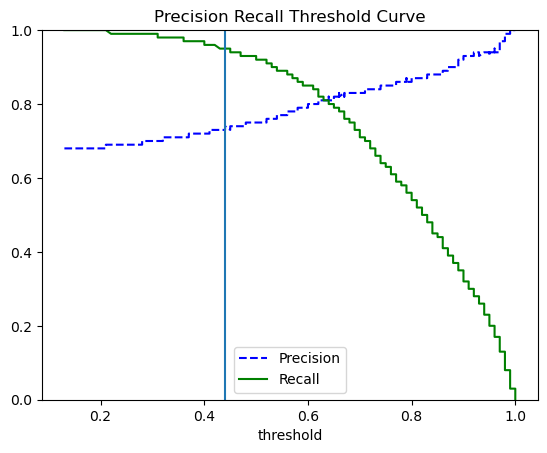

In [381]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, idx)
plt.show()

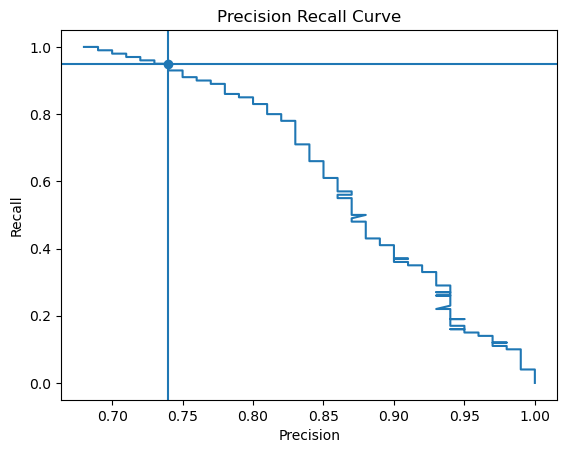

In [382]:
# Plots precision vs recall and pin points the scores
# which were selected for the project
plt.plot(precisions, recalls);
plt.scatter(precisions[idx], recalls[idx]);
plt.axvline(precisions[idx]);
plt.axhline(recalls[idx]);
plt.xlabel('Precision');
plt.ylabel('Recall');
plt.title('Precision Recall Curve');

## Prediction of test set

All we have to do is to clean, resample, and scale the test data and using the fine tuned model, predict the class probabilities for the test set and map all the class probabilities which are less than threshold value as 0 and class probabilities greater than threshold value as 1.

In [383]:
# Create test sets
X_test, y_test = test.drop('completed', axis=1), test.completed.copy(),

In [384]:
# Clean the test set
X_test = data_cleaning(X_test)

In [385]:
# Resample and scale the test set
X_test_scl, y_test = data_prep1(X_test, y_test)

In [386]:
# Threshold value
threshold = thresholds[idx]

In [387]:
# Fine tuned model
model = grid.best_estimator_

In [388]:
# Predicting the class probabilities on test set
y_pred_prob = grid.predict_proba(X_test_scl)

In [389]:
# Mapping the class probabilities based on the threshold value
y_pred = (y_pred_prob[:, 1] >= threshold).astype('int')

In [390]:
precision_score(y_test, y_pred)

0.7239671418216961

In [391]:
recall_score(y_test, y_pred)

0.9525550345704522

In [392]:
f1_score(y_test, y_pred)

0.8226775112392326

Here, as expected, there is a drop in the perfromance of the model on the new instances.

## Reflection

As the project comes to an end, below are some of the highlights of the project identified along the way.


- After merging all three datastes, the data was very unorganized and needed lot of cleaning.


- Restructuring the data was the toughest part of the project as it was very difficult to capture all the data regarding an offer in one single row. This part took major chunk out of total project time. 


- Highlights from the data visualization:
    - Customers with income range of 50-80k (mid income group) have most number of offer completions than high and low income groups
    - Customers with the age range of 50-60 years have most number of offer completions in every offers. In general people with the age range of 40 to 70 years have most number of offer completions and younger population was not much attracted to offers.
    - In BOGO offers, offer 3 was most preferred followed by offer 4.
    - In discount offers, offer 7 was most preferred followed by offer 6.
    - In informational offers, offer 10 was the most preferred offer.
    - Most of the offer completions were done by men, followed by women and others.
    - But, the offer completion rate was highest for women than men and others.
    - Men have ignored most number of offers after viewing and women have ignored least.
    - Women have completed most number of offers unknowingly and others category has least number of unknown offer completions.
    - Among all the genders, offer 6 and 7 were most preferred followed by offers 3 and 4.
    - Again, offer 6 and 7 were most preferred by all income groups.
    - Once again, offers 6 and 7 were most preferred by all age groups.
    

- Random Forest Classifier has performed best among other classifiers with F1 score of 0.7553.


- After resampling technique the F1 score of the random forest classifier increased to 0.8387.


- After hyper-parameter tuning, the F score increased to 0.8457.


- A recall of 0.95 was chosen and the associated precision and threshold values were 0.74 and 0.44


- When predicted on test set using the threshold value, the precision, recall, and f1 scores were 0.723, 0.952, and 0.822 respectively.


## Improvement

- The classifiers used in the project were used with default settings. It might have been useful to use the classifiers with different regularization parameters. 

- Few more parameters with a broader set of values in grid search would have improved the performance of the classifier even more.

## Resources

1. Stackoverflow https://stackoverflow.com/questions
2. W3Schools website https://www.w3schools.com/python
3. Geeksforgeeks website https://www.geeksforgeeks.org/
4. Hands-on Machine Learning with Scikit-Learn and Tensorflow Book by Aurelien Geron.
5. Analytics Vidya Website https://www.analyticsvidhya.com/blog
6. MachineLearniMastery website https://machinelearningmastery.com/
7. Towards Data Science website https://towardsdatascience.com/